In [1]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
np.random.seed(657)

In [2]:
d = 3

In [3]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            return [complex(line.strip()) for line in file.readlines()]
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return []

In [4]:
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    # A = np.asarray(d*[1j/np.sqrt(physical_dim)])
    A = np.array((1/np.sqrt(3)) * np.array([1j, 1, 1j]))
    # A = np.random.rand(3) + 1j * np.random.rand(3)
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [5]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

# ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [6]:
I = ptn.TTNO.Identity(ttn)
ptn.adjust_bra_to_ket(ttn)

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

#ttn = ptn.normalize_ttn_Lindblad_3(ttn , "Site(0,0)" , "Node(0,0)")
#ttn = ptn.normalize_ttn_Lindblad_1(ttn)
for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

ttn.operator_expectation_value_Lindblad(I)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


array(10869688.87818449-4.65661287e-10j)

In [7]:
def Liouville(t, U, J, m, L, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)


    }
    
    conversion_dict.update({
        "it * b^dagger": t*1j * creation_op,
        "it * b": t*1j * annihilation_op,
        "-iU * n * (n - 1)": -U*1j * number_op @ (number_op - np.eye(d)),
        "m*n": m*number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "m*n"}))        
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t*1j * creation_op.T,
        "-it * b.T": -t*1j * annihilation_op.T,
        "iU * n * (n - 1).T": (U*1j * number_op @ (number_op - np.eye(d))).T,
        "-m*n.T": -m * number_op.T

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n.T"}))
            
    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)

    
    J = np.sqrt(J)
    conversion_dict = {    
    "L": J*L,
    "L^dagger.T": J*L.conj(),
    "-1/2 (L^dagger @ L) ": -1/2 * J *  L.conj().T @ L,
    "-1/2 (L^dagger @ L).T":-1/2 * J * (L.conj().T @ L).T}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L) "}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    return H1

In [8]:
def Unitary(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t * 1.0j* creation_op,
        "it * b": t* 1.0j * annihilation_op,
        "-iU * n * (n - 1)": -U* 1.0j * number_op @ (number_op - np.eye(d)),
        "m*n": m * number_op

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "m*n"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t* 1.0j * creation_op.T,
        "-it * b.T": -t* 1.0j * annihilation_op.T,
        "iU * n * (n - 1).T": (U* 1.0j* number_op @ (number_op - np.eye(d))).T,
        "-m*n.T": -m * number_op.T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))   

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n.T"}))         

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)
    return H1

In [9]:
def BoseHubbard_ham(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)}
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "-m*n": -m * number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def BoseHubbard_ham_tp(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, right_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, right_neighbor: creation_op}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, up_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, up_neighbor: creation_op}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: U * number_op @ (number_op - np.eye(d))}))
    
    return terms

In [10]:
def Number_op_total(Lx, Ly, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)     

def Number_op_local( node_id , dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    terms.append(ptn.TensorProduct({node_id: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

In [11]:
def exchange_bra_ket_tensors(ttn):
    state = deepcopy(ttn)
    ptn.adjust_bra_to_ket(state)
    for ket_id in list(state.nodes.keys())[:(len(state.nodes.keys())//2)]:
        i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
        bra_id = f"Node({i},{j})"
        T1 = state.tensors[bra_id]
        T2 = state.tensors[ket_id]
        state.tensors[ket_id] = T1
        state.nodes[ket_id].link_tensor(T1)
        state.tensors[bra_id] = T2
        state.nodes[bra_id].link_tensor(T2)
    return state

def substitute_out_or_in_legs_of_ttn_with_identity(state, out_or_in , bond_dim=2):
    ttn = deepcopy(state)
    if out_or_in == "Out":
       for node_id in list(ttn.nodes.keys())[(len(ttn.nodes.keys())//2):]:
        n = ttn.tensors[node_id].ndim - 1
        T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
        T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
        ttn.tensors[node_id] = T
        ttn.nodes[node_id].link_tensor(T)   
    if out_or_in == "In":
        for node_id in list(ttn.nodes.keys())[:len(ttn.nodes.keys())//2]:
            n = ttn.tensors[node_id].ndim
            T = ttn.tensors[node_id]
            T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
            T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
            ttn.tensors[node_id] = T
            ttn.nodes[node_id].link_tensor(T)        
    return ttn


In [12]:
t = 0.1
U = 0.1
m = 0.1

# TTNO : Hamiltonian acting on in_legs
H1 = BoseHubbard_ham(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = annihilation_op 
J = 0.05
H1 = Liouville(t, U, J, m ,L, 3, 3, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

N = Number_op_total(3, 3, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

n_site_dict = {}
for node in list(ttn.nodes.values())[:(len(ttn.nodes.keys())//2)]:
    node_id = node.identifier
    n_site = Number_op_local(node_id, d)
    n_site = n_site.pad_with_identities(ttn, symbolic=True)
    n_site = ptn.TTNO.from_hamiltonian(n_site, ttn)
    n_site_dict[f'n_{node_id}'] = n_site
n_site_list = list(n_site_dict.values())

# Correlation function
node_id1 = "Site(0,0)"
node_id2 = "Site(2,2)"
H1 = Correlation_function(node_id1, node_id2, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(H1, ttn)

print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N) / ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(H) / ttn.operator_expectation_value_Lindblad(I))
print(np.linalg.norm(ttn.operator_expectation_value_Lindblad(Corr)))


(10869688.878184492-4.656612873077393e-10j)
(9.051131729326626+1.2445606815826782e-15j)
(-0.40817143457125665-3.0873817246222614e-17j)
321008.18416664726


In [13]:
tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = U,
                                     time_step_size = 0.1,
                                     final_time = 8,
                                     operators = [H ,N],
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-1 , total_tol = -np.inf),
                                     expansion_steps = 10,

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 

                                     initial_tol= 1e-18,
                                     tol_step= 10,
                                     rel_tot_bond = 80,
                                     max_bond= 200,
                                     norm_tol= 0,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [14]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 4,
                                     operators = [H ,N],
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-1 , total_tol = -np.inf),
                                     expansion_steps = 30,

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 

                                     initial_tol= 1e-16,
                                     tol_step= 25,
                                     rel_tot_bond = 30,
                                     max_bond= 250,
                                     norm_tol= 0,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [15]:
v

NameError: name 'v' is not defined

In [112]:
tdvp_ex1.run_ex(evaluation_time=1)


  7%|▋         | 30/401 [00:02<00:28, 13.06it/s]

tol : 1e-16


  8%|▊         | 32/401 [00:02<00:45,  8.07it/s]

expanded_dim TTN: 0
TTN: 34 ---> 34
expanded_dim T3NS: 0
T3NS: 50 ---> 50


 15%|█▍        | 60/401 [00:05<00:28, 12.07it/s]

tol : 4e-18
expanded_dim_tot : 51
1) tol 1.0000000000000001e-16


 16%|█▌        | 64/401 [00:05<00:47,  7.10it/s]

2) expanded_dim : 6
expanded_dim TTN: 6
TTN: 34 ---> 40
expanded_dim T3NS: 6
T3NS: 50 ---> 56


 23%|██▎       | 92/401 [00:08<00:25, 12.16it/s]

tol : 1.0000000000000001e-16


 23%|██▎       | 94/401 [00:08<00:48,  6.37it/s]

expanded_dim TTN: 21
TTN: 40 ---> 61
expanded_dim T3NS: 21
T3NS: 64 ---> 85


 31%|███       | 123/401 [00:13<00:41,  6.70it/s]

tol : 1.0000000000000001e-16


 31%|███       | 124/401 [00:14<01:57,  2.37it/s]

expanded_dim TTN: 24
TTN: 61 ---> 85
expanded_dim T3NS: 19
T3NS: 100 ---> 119


 38%|███▊      | 154/401 [00:21<01:01,  4.05it/s]

tol : 1.0000000000000001e-16
expanded_dim_tot : 37
1) tol 2.5000000000000004e-15


 39%|███▊      | 155/401 [00:25<05:16,  1.29s/it]

2) expanded_dim : 4
expanded_dim TTN: 16
TTN: 85 ---> 101
expanded_dim T3NS: 4
T3NS: 139 ---> 143


 46%|████▌     | 185/401 [00:38<01:28,  2.43it/s]

tol : 2.5000000000000004e-15
expanded_dim_tot : 42
1) tol 6.250000000000001e-14


 46%|████▋     | 186/401 [00:43<06:44,  1.88s/it]

2) expanded_dim : -7
expanded_dim TTN: 9
TTN: 101 ---> 110
expanded_dim T3NS: -7
T3NS: 167 ---> 160


 54%|█████▍    | 216/401 [01:01<01:48,  1.70it/s]

tol : 2.5000000000000004e-15
expanded_dim_tot : 155
1) tol 6.250000000000001e-14
2) expanded_dim : 54
1) tol 1.5625000000000003e-12


 54%|█████▍    | 217/401 [01:17<15:48,  5.16s/it]

2) expanded_dim : -7
expanded_dim TTN: 11
TTN: 110 ---> 121
expanded_dim T3NS: -7
T3NS: 182 ---> 175


 62%|██████▏   | 247/401 [01:49<02:46,  1.08s/it]

tol : 6.250000000000001e-14
expanded_dim_tot : 177
1) tol 1.5625000000000003e-12
2) expanded_dim : 57
1) tol 3.906250000000001e-11


 62%|██████▏   | 248/401 [02:25<29:05, 11.41s/it]

2) expanded_dim : -25
expanded_dim TTN: 13
TTN: 121 ---> 134
expanded_dim T3NS: -25
T3NS: 218 ---> 193


 69%|██████▉   | 278/401 [03:54<05:59,  2.92s/it]

tol : 1.5625000000000003e-12
expanded_dim_tot : 219
1) tol 3.906250000000001e-11
2) expanded_dim : 79
1) tol 9.765625000000002e-10


 70%|██████▉   | 279/401 [05:06<47:43, 23.47s/it]

2) expanded_dim : -20
expanded_dim TTN: 27
TTN: 134 ---> 161
expanded_dim T3NS: -20
T3NS: 245 ---> 225


 77%|███████▋  | 309/401 [18:39<34:13, 22.33s/it]

tol : 3.906250000000001e-11
expanded_dim_tot : 310
1) tol 9.765625000000002e-10
2) expanded_dim : 144
1) tol 2.4414062500000004e-08
2) expanded_dim : 3


 77%|███████▋  | 310/401 [23:53<2:46:47, 109.97s/it]

expanded_dim TTN: 56
TTN: 161 ---> 217
expanded_dim T3NS: 3
T3NS: 287 ---> 290


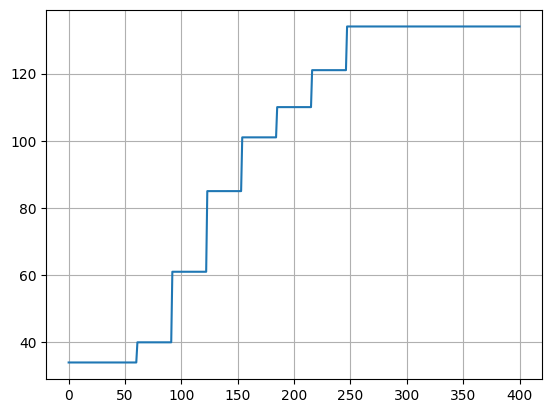

In [113]:
import matplotlib.pyplot as plt

#plt.plot(tdvp_ex1.max_bond_dim)
plt.plot(tdvp_ex1.total_bond_dim)
plt.grid(True)

plt.show()


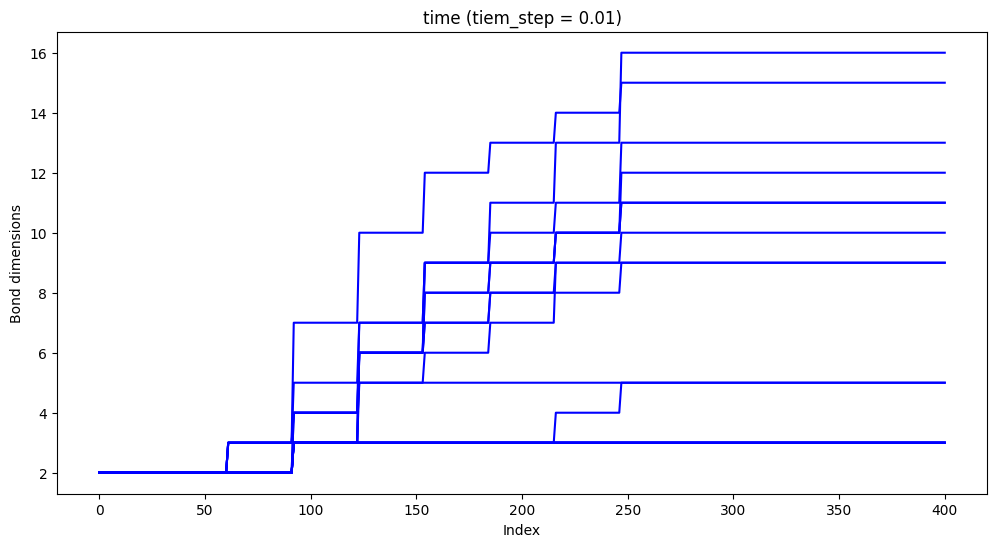

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for key, values in tdvp_ex1.bond_dims.items():
    x = list(range(len(values)))
    ax.plot(x, values, color='blue')

#blue_patch = plt.Line2D([0], [0], color='blue', label='QR-split form (8 min)')

ax.set_xlabel('Index')
ax.set_ylabel('Bond dimensions')
ax.set_title('time (tiem_step = 0.01)')


plt.show()


In [117]:
times = tdvp_ex1.times()
results_H = tdvp_ex1.operator_results()[0]
results_N = tdvp_ex1.operator_results()[1]
results_N

array([ 9.05113173+1.21537083e-15j,  9.05113586+9.64490346e-03j,
        9.05114826+1.92912180e-02j,  9.05116897+2.89388698e-02j,
        9.051198  +3.85877863e-02j,  9.05123537+4.82378959e-02j,
        9.0512811 +5.78891283e-02j,  9.05133521+6.75414144e-02j,
        9.05139773+7.71946862e-02j,  9.05146866+8.68488768e-02j,
        9.05154804+9.65039204e-02j,  9.05163588+1.06159752e-01j,
        9.05173219+1.15816309e-01j,  9.05183699+1.25473528e-01j,
        9.0519503 +1.35131348e-01j,  9.05207215+1.44789709e-01j,
        9.05220253+1.54448550e-01j,  9.05234148+1.64107814e-01j,
        9.05248901+1.73767443e-01j,  9.05264513+1.83427381e-01j,
        9.05280986+1.93087572e-01j,  9.05298322+2.02747962e-01j,
        9.05316522+2.12408497e-01j,  9.05335588+2.22069124e-01j,
        9.05355521+2.31729791e-01j,  9.05376324+2.41390446e-01j,
        9.05397998+2.51051041e-01j,  9.05420545+2.60711524e-01j,
        9.05443966+2.70371847e-01j,  9.05468264+2.80031962e-01j,
        9.0549344 +2.8969

In [118]:
results_4 = np.array([ 9.05113173+1.21537083e-15j,  9.05113586+9.64490346e-03j,
        9.05114826+1.92912180e-02j,  9.05116897+2.89388698e-02j,
        9.051198  +3.85877863e-02j,  9.05123537+4.82378959e-02j,
        9.0512811 +5.78891283e-02j,  9.05133521+6.75414144e-02j,
        9.05139773+7.71946862e-02j,  9.05146866+8.68488768e-02j,
        9.05154804+9.65039204e-02j,  9.05163588+1.06159752e-01j,
        9.05173219+1.15816309e-01j,  9.05183699+1.25473528e-01j,
        9.0519503 +1.35131348e-01j,  9.05207215+1.44789709e-01j,
        9.05220253+1.54448550e-01j,  9.05234148+1.64107814e-01j,
        9.05248901+1.73767443e-01j,  9.05264513+1.83427381e-01j,
        9.05280986+1.93087572e-01j,  9.05298322+2.02747962e-01j,
        9.05316522+2.12408497e-01j,  9.05335588+2.22069124e-01j,
        9.05355521+2.31729791e-01j,  9.05376324+2.41390446e-01j,
        9.05397998+2.51051041e-01j,  9.05420545+2.60711524e-01j,
        9.05443966+2.70371847e-01j,  9.05468264+2.80031962e-01j,
        9.0549344 +2.89691821e-01j,  9.05519496+2.99351377e-01j,
        9.05546434+3.09010583e-01j,  9.05574256+3.18669394e-01j,
        9.05602964+3.28327764e-01j,  9.05632561+3.37985647e-01j,
        9.05663048+3.47642999e-01j,  9.05694429+3.57299776e-01j,
        9.05726705+3.66955933e-01j,  9.05759879+3.76611426e-01j,
        9.05793954+3.86266210e-01j,  9.05828933+3.95920243e-01j,
        9.05864818+4.05573479e-01j,  9.05901613+4.15225875e-01j,
        9.0593932 +4.24877386e-01j,  9.05977944+4.34527966e-01j,
        9.06017488+4.44177572e-01j,  9.06057955+4.53826158e-01j,
        9.0609935 +4.63473676e-01j,  9.06141677+4.73120081e-01j,
        9.06184939+4.82765324e-01j,  9.06229142+4.92409356e-01j,
        9.0627429 +5.02052129e-01j,  9.06320388+5.11693590e-01j,
        9.06367441+5.21333688e-01j,  9.06415455+5.30972369e-01j,
        9.06464435+5.40609577e-01j,  9.06514388+5.50245257e-01j,
        9.06565319+5.59879348e-01j,  9.06617236+5.69511790e-01j,
        9.06670145+5.79142520e-01j,  9.06724053+5.88771473e-01j,
        9.06778968+5.98398580e-01j,  9.06818491+6.07967679e-01j,
        9.06861482+6.17497116e-01j,  9.06906381+6.27018535e-01j,
        9.06952536+6.36534933e-01j,  9.06999705+6.46047192e-01j,
        9.07047767+6.55555698e-01j,  9.07096648+6.65060647e-01j,
        9.07146299+6.74562143e-01j,  9.07196687+6.84060241e-01j,
        9.07247782+6.93554962e-01j,  9.07299563+7.03046305e-01j,
        9.07352011+7.12534252e-01j,  9.0740511 +7.22018772e-01j,
        9.07458845+7.31499822e-01j,  9.07513203+7.40977346e-01j,
        9.07568171+7.50451282e-01j,  9.07623738+7.59921556e-01j,
        9.07679892+7.69388087e-01j,  9.07736624+7.78850783e-01j,
        9.07793922+7.88309544e-01j,  9.07851777+7.97764259e-01j,
        9.07910178+8.07214810e-01j,  9.07969117+8.16661068e-01j,
        9.08028584+8.26102892e-01j,  9.0808857 +8.35540134e-01j,
        9.08149064+8.44972632e-01j,  9.08210059+8.54400216e-01j,
        9.08271545+8.63822700e-01j,  9.08333513+8.73239891e-01j,
        9.08395955+8.82651578e-01j,  9.0845886 +8.92057542e-01j,
        9.0853263 +9.01860452e-01j,  9.086062  +9.11745975e-01j,
        9.08681743+9.21648197e-01j,  9.08758917+9.31561100e-01j,
        9.08837579+9.41481982e-01j,  9.08917634+9.51409355e-01j,
        9.08999   +9.61342326e-01j,  9.09081602+9.71280339e-01j,
        9.09165367+9.81223038e-01j,  9.09250228+9.91170194e-01j,
        9.0933612 +1.00112165e+00j,  9.0942298 +1.01107730e+00j,
        9.0951075 +1.02103707e+00j,  9.09599374+1.03100088e+00j,
        9.09688799+1.04096866e+00j,  9.09778976+1.05094035e+00j,
        9.09869857+1.06091586e+00j,  9.09961396+1.07089510e+00j,
        9.10053551+1.08087798e+00j,  9.10146279+1.09086437e+00j,
        9.10239542+1.10085413e+00j,  9.10333299+1.11084712e+00j,
        9.10427516+1.12084316e+00j,  9.10522155+1.13084207e+00j,
        9.10617181+1.14084363e+00j,  9.10712561+1.15084763e+00j,
        9.1080826 +1.16085381e+00j,  9.10904247+1.17086190e+00j,
        9.11000488+1.18087162e+00j,  9.11096953+1.19088266e+00j,
        9.1119361 +1.20089468e+00j,  9.11340767+1.21070992e+00j,
        9.11489667+1.22041567e+00j,  9.11636688+1.23009873e+00j,
        9.11783034+1.23977553e+00j,  9.11928797+1.24944626e+00j,
        9.12073936+1.25910953e+00j,  9.12218373+1.26876394e+00j,
        9.1236202 +1.27840820e+00j,  9.12504785+1.28804115e+00j,
        9.12646573+1.29766168e+00j,  9.12787291+1.30726873e+00j,
        9.1292684 +1.31686127e+00j,  9.13065123+1.32643825e+00j,
        9.13202039+1.33599862e+00j,  9.13337486+1.34554132e+00j,
        9.1347136 +1.35506524e+00j,  9.13603553+1.36456927e+00j,
        9.13733956+1.37405223e+00j,  9.13862457+1.38351295e+00j,
        9.13988942+1.39295017e+00j,  9.14113292+1.40236262e+00j,
        9.14235388+1.41174896e+00j,  9.14355105+1.42110781e+00j,
        9.14472319+1.43043774e+00j,  9.14586899+1.43973726e+00j,
        9.14698713+1.44900482e+00j,  9.14807628+1.45823882e+00j,
        9.14913505+1.46743758e+00j,  9.15016204+1.47659938e+00j,
        9.15115581+1.48572240e+00j,  9.15211491+1.49480476e+00j,
        9.15302944+1.50426499e+00j,  9.1540533 +1.51346579e+00j,
        9.15513542+1.52253499e+00j,  9.15622844+1.53152051e+00j,
        9.15731841+1.54043780e+00j,  9.15839961+1.54929295e+00j,
        9.15946899+1.55808818e+00j,  9.16052463+1.56682386e+00j,
        9.16156513+1.57549935e+00j,  9.16258939+1.58411336e+00j,
        9.16359651+1.59266425e+00j,  9.16458576+1.60115006e+00j,
        9.16555651+1.60956862e+00j,  9.16650828+1.61791760e+00j,
        9.16744067+1.62619450e+00j,  9.16835341+1.63439668e+00j,
        9.16924633+1.64252141e+00j,  9.17011936+1.65056581e+00j,
        9.17097257+1.65852690e+00j,  9.17180614+1.66640157e+00j,
        9.17262038+1.67418662e+00j,  9.17341576+1.68187872e+00j,
        9.17419288+1.68947445e+00j,  9.17495253+1.69697024e+00j,
        9.17569564+1.70436243e+00j,  9.17642336+1.71164724e+00j,
        9.17713703+1.71882076e+00j,  9.17783821+1.72587896e+00j,
        9.17852872+1.73281769e+00j,  9.17921061+1.73963268e+00j,
        9.17988622+1.74631950e+00j,  9.18038019+1.75265823e+00j,
        9.18078197+1.75903786e+00j,  9.18119618+1.76530019e+00j,
        9.18161873+1.77142101e+00j,  9.18205408+1.77739192e+00j,
        9.18250755+1.78320714e+00j,  9.18298501+1.78886162e+00j,
        9.18349284+1.79435062e+00j,  9.18403804+1.79966949e+00j,
        9.18462826+1.80481364e+00j,  9.18527184+1.80977853e+00j,
        9.18597782+1.81455963e+00j,  9.18675604+1.81915245e+00j,
        9.18761712+1.82355254e+00j,  9.18857256+1.82775553e+00j,
        9.18963477+1.83175711e+00j,  9.1908171 +1.83555311e+00j,
        9.19213393+1.83913946e+00j,  9.19360072+1.84251229e+00j,
        9.19523404+1.84566790e+00j,  9.19705171+1.84860287e+00j,
        9.19907277+1.85131403e+00j,  9.20131764+1.85379856e+00j,
        9.20380811+1.85605404e+00j,  9.2065675 +1.85807849e+00j,
        9.20962066+1.85987043e+00j,  9.21299412+1.86142900e+00j,
        9.21671609+1.86275399e+00j,  9.22081664+1.86384593e+00j,
        9.22532771+1.86470624e+00j,  9.23028321+1.86533726e+00j,
        9.23344652+1.86343193e+00j,  9.2362261 +1.86144416e+00j,
        9.23953358+1.85917921e+00j,  9.24340902+1.85649645e+00j,
        9.24787958+1.85333823e+00j,  9.2529779 +1.84967196e+00j,
        9.25874327+1.84547519e+00j,  9.26522118+1.84073042e+00j,
        9.27246284+1.83542307e+00j,  9.28052491+1.82954061e+00j,
        9.28946933+1.82307219e+00j,  9.29936335+1.81600858e+00j,
        9.31027958+1.80834223e+00j,  9.32229612+1.80006739e+00j,
        9.33549673+1.79118038e+00j,  9.34997107+1.78167980e+00j,
        9.36581492+1.77156692e+00j,  9.38313044+1.76084595e+00j,
        9.40202644+1.74952452e+00j,  9.4226187 +1.73761407e+00j,
        9.44503028+1.72513035e+00j,  9.4693918 +1.71209395e+00j,
        9.49584181+1.69853087e+00j,  9.5245271 +1.68447318e+00j,
        9.55560306+1.66995965e+00j,  9.58923404+1.65503651e+00j,
        9.62559366+1.63975828e+00j,  9.66486526+1.62418854e+00j,
        9.70724221+1.60840096e+00j,  9.75292832+1.59248022e+00j,
        9.80213826+1.57652308e+00j,  9.85305273+1.55424413e+00j,
        9.90400185+1.52587721e+00j,  9.95752016+1.49649142e+00j,
       10.01434738+1.46646393e+00j, 10.0748081 +1.43589981e+00j,
       10.13913657+1.40486715e+00j, 10.20753848+1.37342769e+00j,
       10.28020913+1.34164275e+00j, 10.35734053+1.30957399e+00j,
       10.43912463+1.27728287e+00j, 10.52575526+1.24482958e+00j,
       10.61742947+1.21227166e+00j, 10.71434872+1.17966252e+00j,
       10.81672003+1.14704969e+00j, 10.92475728+1.11447289e+00j,
       11.03868271+1.08196194e+00j, 11.15872847+1.04953439e+00j,
       11.28513866+1.01719294e+00j, 11.41817141+9.84922542e-01j,
       11.55810142+9.52687175e-01j, 11.70522277+9.20426251e-01j,
       11.85985206+8.88050550e-01j, 12.022332  +8.55437626e-01j,
       12.19303526+8.22426572e-01j, 12.37236889+7.88811992e-01j,
       12.56077903+7.54337038e-01j, 12.75875612+7.18685295e-01j,
       12.96684047+6.81471241e-01j, 13.18562832+6.42228988e-01j,
       13.41577817+6.00398884e-01j, 13.6580174 +5.55311489e-01j,
       13.91314905+5.06168318e-01j, 14.18205841+4.52018576e-01j,
       14.46571926+3.91730966e-01j, 14.76519895+3.23959392e-01j,
       15.08166182+2.47101126e-01j, 15.41636944+1.59245697e-01j,
       15.77067621+5.81123654e-02j, 16.14601742-5.90263730e-02j,
       16.54388626-1.95438235e-01j, 16.96579417-3.55044956e-01j,
       17.4132067 -5.42560094e-01j, 17.8874436 -7.63654297e-01j,
       18.38952715-1.02515055e+00j, 18.91995606-1.33524936e+00j,
       19.47837388-1.70377839e+00j, 20.06308987-2.14245080e+00j,
       20.67039764-2.66509790e+00j, 21.29362573-3.28780980e+00j,
       21.92184977-4.02886648e+00j, 22.53821265-4.90826320e+00j,
       23.11786316-5.94652710e+00j, 23.62567663-7.16239816e+00j,
       24.01422159-8.56886201e+00j, 24.2229268 -1.01671017e+01j,
       24.18003125-1.19384132e+01j, 23.80936053-1.38352853e+01j,
       23.04355993-1.57747253e+01j, 21.84318727-1.76387979e+01j,
       20.21681594-1.92873048e+01j, 18.23306063-2.05834049e+01j,
       16.0155484 -2.14252098e+01j, 13.7191088 -2.17702217e+01j,
       11.49609723-2.16413708e+01j,  9.4671888 -2.11133310e+01j,
        7.70678519-2.02878370e+01j,  6.24393343-1.92695196e+01j,
        5.07294498-1.81495472e+01j,  4.1667394 -1.69984032e+01j,
        3.48832718-1.58654442e+01j,  2.99874749-1.47820537e+01j,
        2.66163761-1.37659427e+01j,  2.44533181-1.28252239e+01j,
        2.32342566-1.19617070e+01j,  2.27451783-1.11733280e+01j,
        2.28158825-1.04558315e+01j,  2.33127441-9.80388073e+00j,
        2.41317804-9.21175743e+00j,  2.51925825-8.67378390e+00j,
        2.64332626-8.18456113e+00j,  2.78063726-7.73909015e+00j,
        2.92756693-7.33282120e+00j,  3.08135798-6.96165972e+00j,
        3.23992312-6.62194809e+00j,  3.40169254-6.31043478e+00j,
        3.56549602-6.02423810e+00j,  3.73047203-5.76080884e+00j,
        3.89599756-5.51789416e+00j,  4.06163399-5.29350412e+00j,
        4.22708518-5.08588128e+00j,  4.39216513-4.89347363e+00j,
        4.55677294-4.71491069e+00j,  4.72087336-4.54898264e+00j,
        4.8844818 -4.39462215e+00j,  5.04765257-4.25088866e+00j,
        5.21046989-4.11695481e+00j,  5.37304078-3.99209487e+00j,
        5.53548964-3.87567471e+00j,  5.69795388-3.76714338e+00j,
        5.8605806 -3.66602593e+00j,  6.0235239 -3.57191736e+00j,
        6.18694263-3.48447762e+00j,  6.35099861-3.40342752e+00j,
        6.51585501-3.32854540e+00j,  6.68167478-3.25966457e+00j,
        6.84861924-3.19667141e+00j,  7.01684648-3.13950408e+00j,
        7.18650963-3.08815170e+00j,  7.35775486-3.04265416e+00j,
        7.53071909-3.00310224e+00j,  7.70552718-2.96963828e+00j,
        7.88228858-2.94245704e+00j,  8.0610934 -2.92180694e+00j,
        8.24200756-2.90799145e+00j,  8.42506706-2.90137057e+00j,
        8.61027121-2.90236218e+00j,  8.79757453-2.91144324e+00j,
        8.98687735-2.92915044e+00j,  9.17801471-2.95608007e+00j,
        9.37074373-2.99288668e+00j,  9.5647291 -3.04028023e+00j,
        9.75952672-3.09902083e+00j,  9.95456569-3.16991067e+00j,
       10.14912869-3.25378221e+00j, 10.3423313 -3.35148166e+00j,
       10.53310095-3.46384684e+00j, 10.72015655-3.59167826e+00j,
       10.90199043-3.73570263e+00j, 11.07685456-3.89652793e+00j,
       11.24275367-4.07458965e+00j, 11.39744861-4.27008869e+00j,
       11.53847339-4.48292210e+00j, 11.66316986-4.71260922e+00j,
       11.76874361-4.95821760e+00j, 11.85234388-5.21829445e+00j,
       11.91116846-5.49081149e+00j, 11.94259249-5.77313206e+00j,
       11.94431599-6.06201006e+00j, 11.91452192-6.35362926e+00j,
       11.85203185-6.64368888e+00j, 11.75644422-6.92753727e+00j,
       11.62823799-7.20034919e+00j, 11.46882673-7.45733609e+00j,
       11.28055153-7.69397238e+00j, 11.06660832-7.90621705e+00j,
       10.83091313-8.09070836e+00j, 10.57791719-8.24491255e+00j,
       10.31238989-8.36721260e+00j, 10.03919141-8.45693159e+00j,
        9.76305642-8.51429293e+00j,  9.48840705-8.54032753e+00j,
        9.21920749-8.53674235e+00j])

In [17]:
results_3 = np.array

In [18]:
results_3_conj = np.array([9.        +0.00000000e+00j, 8.99936944-1.70937100e-05j,
       8.99752004-4.25245726e-05j, 8.99441989-7.19874183e-05j,
       8.99005977-1.03704119e-04j, 8.98442513-1.36492485e-04j,
       8.97749526-1.69482774e-04j, 8.96924197-2.02052265e-04j,
       8.95962808-2.33813783e-04j, 8.94860571-2.64619690e-04j,
       8.93611432-2.94569835e-04j, 8.92207838-3.24019863e-04j,
       8.91598064-1.28009465e-03j, 8.90857019-2.03392990e-03j,
       8.90066355-2.59277533e-03j, 8.89232137-3.06779970e-03j,
       8.88352897-3.49372296e-03j, 8.87425616-3.87606991e-03j,
       8.86444982-4.20394762e-03j, 8.85402933-4.45338810e-03j,
       8.8428892 -4.58862011e-03j, 8.83091031-4.56338969e-03j,
       8.81798002-4.32275641e-03j, 8.81006741-9.43455666e-04j,
       8.80158712+1.87182797e-03j, 8.79266651+4.30001233e-03j,
       8.7837369 +6.49491530e-03j, 8.77521015+8.52194796e-03j,
       8.76756492+1.04067425e-02j, 8.76141662+1.21486551e-02j,
       8.75760021+1.37197873e-02j, 8.75727456+1.50564170e-02j,
       8.76205402+1.60458523e-02j, 8.77416716+1.65128989e-02j,
       8.76341253+2.55458973e-02j, 8.7510169 +1.40256022e-02j,
       8.74938785+1.96268058e-03j, 8.75681274-1.00128238e-02j,
       8.77405306-2.12556197e-02j, 8.80192875-3.16507740e-02j,
       8.84099146-4.44521953e-02j])

In [19]:
results_1_conj = np.array([9.        +0.00000000e+00j, 8.99936944-1.70937100e-05j,
       8.99752004-4.25245726e-05j, 8.99441989-7.19874183e-05j,
       8.99005977-1.03704119e-04j, 8.98442513-1.36492485e-04j,
       8.97749526-1.69482774e-04j, 8.96924197-2.02052265e-04j,
       8.95962808-2.33813783e-04j, 8.94860571-2.64619690e-04j,
       8.93611432-2.94569835e-04j, 8.92207838-3.24020156e-04j,
       8.91844937-7.27786864e-04j, 8.91457694-9.75664168e-04j,
       8.9105033 -1.20788678e-03j, 8.90616455-1.43697351e-03j,
       8.90151483-1.66263377e-03j, 8.89650344-1.87881701e-03j,
       8.89107291-2.07701456e-03j, 8.8851634 -2.24859216e-03j,
       8.87872085-2.38640313e-03j, 8.87170604-2.48557393e-03j,
       8.86410287-2.54351262e-03j, 8.85015327+8.03419312e-04j,
       8.84011533+4.67271655e-03j, 8.83102366+8.50387300e-03j,
       8.82282894+1.24894334e-02j, 8.81588127+1.67265202e-02j,
       8.81065354+2.12974126e-02j, 8.80773382+2.62728360e-02j,
       8.80783509+3.16887666e-02j, 8.81180066+3.74991492e-02j,
       8.82060281+4.35093093e-02j, 8.83534176+4.93066935e-02j,
       8.84062453+5.50386310e-02j, 8.84908423+5.38134337e-02j,
       8.85995085+5.34025517e-02j, 8.87383676+5.40659127e-02j,
       8.89231141+5.57861324e-02j, 8.91831163+5.84878730e-02j,
       8.95658935+6.23198725e-02j])

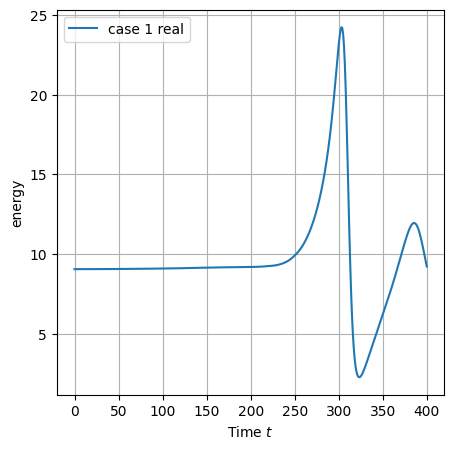

In [116]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5,5))

axs1.plot( np.real(results_N) , label="case 1 real")
#axs1.plot( results_4 , label="results_3")

#axs1.plot( results_3 , label="results_3")
#axs1.plot( results_3_conj , label="results_3_conj")
#axs1.plot( results_1_conj , label="results_1_conj")

#axs1.plot( results_1 , label="results_1")
#axs1.plot( np.real(esults_no_norm), label="esults_no_norm")

#axs1.plot( results_1_conj, label="results_1_conj")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.grid(True)
axs1.legend()

In [23]:
results_3 = np.array([  9.09352523+3.43450294e-16j,   9.09352409+3.12955472e-02j,
         9.09352073+6.25723421e-02j,   9.09351512+9.38326206e-02j,
         9.09350716+1.25078600e-01j,   9.09349664+1.56312476e-01j,
         9.09348325+1.87536418e-01j,   9.09346658+2.18752569e-01j,
         9.09344613+2.49963036e-01j,   9.0934213 +2.81169894e-01j,
         9.09339138+3.12375176e-01j,   9.09335558+3.43580870e-01j,
         9.09331299+3.74788918e-01j,   9.09326261+4.06001211e-01j,
         9.09320332+4.37219579e-01j,   9.09313392+4.68445794e-01j,
         9.09305309+4.99681562e-01j,   9.09295939+5.30928515e-01j,
         9.0928513 +5.62188210e-01j,   9.09272717+5.93462121e-01j,
         9.09258524+6.24751633e-01j,   9.09242364+6.56058035e-01j,
         9.09224039+6.87382516e-01j,   9.09203339+7.18726154e-01j,
         9.09180041+7.50089913e-01j,   9.09153913+7.81474629e-01j,
         9.09124708+8.12881006e-01j,   9.09092169+8.44309606e-01j,
         9.09056027+8.75760840e-01j,   9.09015999+9.07234954e-01j,
         9.08971792+9.38732024e-01j,   9.08923099+9.70251940e-01j,
         9.0886951 +1.00165840e+00j,   9.08814683+1.03309331e+00j,
         9.08759025+1.06453294e+00j,   9.08701901+1.09597263e+00j,
         9.08642963+1.12740883e+00j,   9.0858197 +1.15883811e+00j,
         9.08518747+1.19025684e+00j,   9.08453158+1.22166111e+00j,
         9.08385102+1.25304666e+00j,   9.08314511+1.28440888e+00j,
         9.0824135 +1.31574271e+00j,   9.08165615+1.34704270e+00j,
         9.08087343+1.37830292e+00j,   9.0800661 +1.40951698e+00j,
         9.07923537+1.44067800e+00j,   9.07831676+1.47164644e+00j,
         9.07727228+1.50266809e+00j,   9.07619537+1.53369210e+00j,
         9.07508369+1.56468488e+00j,   9.07393269+1.59563044e+00j,
         9.07273965+1.62651608e+00j,   9.07150293+1.65732973e+00j,
         9.0702217 +1.68805903e+00j,   9.06889593+1.71869101e+00j,
         9.06752635+1.74921185e+00j,   9.06611451+1.77960680e+00j,
         9.06466289+1.80986004e+00j,   9.06317496+1.83995460e+00j,
         9.06165535+1.86987231e+00j,   9.06010994+1.89959367e+00j,
         9.05854603+1.92909784e+00j,   9.05660909+1.95896402e+00j,
         9.05496208+1.98847829e+00j,   9.05332986+2.01779892e+00j,
         9.05168258+2.04688616e+00j,   9.05002033+2.07570881e+00j,
         9.04835108+2.10423725e+00j,   9.0466869 +2.13244165e+00j,
         9.04504294+2.16029122e+00j,   9.04343719+2.18775389e+00j,
         9.04189055+2.21479601e+00j,   9.04042701+2.24138222e+00j,
         9.03907389+2.26747530e+00j,   9.03786215+2.29303602e+00j,
         9.03682669+2.31802310e+00j,   9.0360068 +2.34239308e+00j,
         9.03546953+2.36594529e+00j,   9.03517109+2.38867937e+00j,
         9.03521589+2.41067241e+00j,   9.03568732+2.43177213e+00j,
         9.03667129+2.45188732e+00j,   9.03826101+2.47093736e+00j,
         9.04055852+2.48884352e+00j,   9.04367566+2.50552638e+00j,
         9.04773487+2.52090477e+00j,   9.05286998+2.53489541e+00j,
         9.05922693+2.54741257e+00j,   9.06696448+2.55836801e+00j,
         9.07625472+2.56767079e+00j,   9.0872836 +2.57522710e+00j,
         9.10025124+2.58093996e+00j,   9.11537208+2.58470878e+00j,
         9.13238327+2.58553509e+00j,   9.15147048+2.58436747e+00j,
         9.17325812+2.58086009e+00j,   9.19811435+2.57488439e+00j,
         9.22637694+2.56632640e+00j,   9.25837916+2.55506840e+00j,
         9.29445642+2.54098596e+00j,   9.33494652+2.52394571e+00j,
         9.38018701+2.50380280e+00j,   9.43051078+2.48039771e+00j,
         9.48623987+2.45355266e+00j,   9.5476778 +2.42306749e+00j,
         9.61510013+2.38871545e+00j,   9.68874313+2.35023899e+00j,
         9.76879048+2.30734611e+00j,   9.85630083+2.26107635e+00j,
         9.95263206+2.21156328e+00j,  10.05527401+2.15612960e+00j,
        10.16397541+2.09440656e+00j,  10.27835425+2.02575952e+00j,
        10.39778493+1.94953509e+00j,  10.5213952 +1.86511566e+00j,
        10.64805887+1.77196879e+00j,  10.77639653+1.66970826e+00j,
        10.90479351+1.55816511e+00j,  11.03144212+1.43746274e+00j,
        11.15441258+1.30808671e+00j,  11.27175289+1.17093749e+00j,
        11.38161262+1.02735344e+00j,  11.48237935+8.79092875e-01j,
        11.57281125+7.28269320e-01j,  11.65548309+5.76489420e-01j,
        11.7315876 +4.21597783e-01j,  11.79512261+2.69522002e-01j,
        11.84598638+1.23542218e-01j,  11.88523682-1.36849171e-02j,
        11.9145724 -1.40047606e-01j,  11.93608799-2.54031520e-01j,
        11.9520667 -3.54737806e-01j,  11.9647992 -4.41847509e-01j,
        11.97644143-5.15542135e-01j,  11.9889174 -5.76398300e-01j,
        12.00386626-6.25274503e-01j,  12.0226269 -6.63204199e-01j,
        12.0462508 -6.91304127e-01j,  12.07553307-7.10701914e-01j,
        12.11105319-7.22483231e-01j,  12.15321895-7.27656478e-01j,
        12.20230908-7.27131802e-01j,  12.25851216-7.21711023e-01j,
        12.32196056-7.12085296e-01j,  12.3927592 -6.98837837e-01j,
        12.47100961-6.82449637e-01j,  12.55682989-6.63306582e-01j,
        12.65037146-6.41706895e-01j,  12.75183351-6.17868117e-01j,
        12.86147596-5.91933110e-01j,  12.97963173-5.63974719e-01j,
        13.10671916-5.33998824e-01j,  13.24325528-5.01945546e-01j,
        13.38987077-4.67688351e-01j,  13.5473275 -4.31030724e-01j,
        13.71653958-3.91699985e-01j,  13.89859926-3.49337621e-01j,
        14.09480915-3.03485278e-01j,  14.30672278-2.53565176e-01j,
        14.5361963 -1.98853174e-01j,  14.78545477-1.38441965e-01j,
        15.05717818-7.11907162e-02j,  15.35461425+4.34427412e-03j,
        15.68172785+9.00059965e-02j,  16.04340155+1.88172582e-01j,
        16.44570829+3.01951784e-01j,  16.89628784+4.35464648e-01j,
        17.40487487+5.94268342e-01j,  17.9840531 +7.86002191e-01j,
        18.65035358+1.02140323e+00j,  19.42588793+1.31595547e+00j,
        20.34083186+1.69267096e+00j,  21.43728712+2.18698878e+00j,
        22.77540731+2.85585754e+00j,  24.44321212+3.79562181e+00j,
        26.57196499+5.17986327e+00j,  29.35698454+7.34654830e+00j,
        33.06361029+1.10191660e+01j,  37.85331326+1.79217795e+01j,
        42.21842199+3.24295142e+01j,  32.85004577+6.10361431e+01j,
       -15.19900789+6.86043267e+01j, -33.78931383+3.20947920e+01j,
       -25.89362068+1.21309794e+01j, -17.80288317+4.33630447e+00j,
       -12.12436907+9.40608584e-01j,  -8.17371826-7.48076394e-01j,
        -5.33010907-1.68400691e+00j,  -3.20934868-2.25037466e+00j,
        -1.57919927-2.61931855e+00j,  -0.29515376-2.87536902e+00j,
         0.7361758 -3.06298861e+00j,   1.5774169 -3.20681342e+00j,
         2.27202211-3.32102412e+00j,   2.85108889-3.41399966e+00j,
         3.33751429-3.49077131e+00j,   3.74860707-3.55438616e+00j,
         4.09777588-3.60670050e+00j,   4.39564579-3.64886074e+00j,
         4.65081059-3.68160459e+00j])

In [24]:
results_1 = np.array([ 9.09352523+3.43450294e-16j,  9.09352409+3.12955472e-02j,
        9.09352073+6.25723421e-02j,  9.09351512+9.38326206e-02j,
        9.09350716+1.25078600e-01j,  9.09349664+1.56312476e-01j,
        9.09348325+1.87536418e-01j,  9.09346658+2.18752569e-01j,
        9.09344613+2.49963036e-01j,  9.0934213 +2.81169894e-01j,
        9.09339138+3.12375176e-01j,  9.09335558+3.43580870e-01j,
        9.09331299+3.74788918e-01j,  9.09326261+4.06001211e-01j,
        9.09320332+4.37219579e-01j,  9.09313392+4.68445794e-01j,
        9.09305309+4.99681562e-01j,  9.09295939+5.30928515e-01j,
        9.0928513 +5.62188210e-01j,  9.09272717+5.93462121e-01j,
        9.09258524+6.24751633e-01j,  9.09242364+6.56058035e-01j,
        9.09224039+6.87382516e-01j,  9.09203339+7.18726154e-01j,
        9.09180041+7.50089913e-01j,  9.09153913+7.81474629e-01j,
        9.09124708+8.12881006e-01j,  9.09092169+8.44309606e-01j,
        9.09056027+8.75760840e-01j,  9.09015999+9.07234954e-01j,
        9.08971792+9.38732024e-01j,  9.08923099+9.70251940e-01j,
        9.08868687+1.00180067e+00j,  9.08809113+1.03337404e+00j,
        9.08743822+1.06496922e+00j,  9.08672447+1.09658495e+00j,
        9.08594609+1.12821974e+00j,  9.08509916+1.15987182e+00j,
        9.08417969+1.19153915e+00j,  9.08318357+1.22321933e+00j,
        9.08210661+1.25490968e+00j,  9.08094454+1.28660712e+00j,
        9.07969302+1.31830823e+00j,  9.07834765+1.35000916e+00j,
        9.07690397+1.38170567e+00j,  9.07535751+1.41339303e+00j,
        9.0737038 +1.44506606e+00j,  9.07154069+1.47674682e+00j,
        9.06950345+1.50826622e+00j,  9.06758896+1.53962719e+00j,
        9.06567552+1.57086430e+00j,  9.06373526+1.60198123e+00j,
        9.06175837+1.63297308e+00j,  9.05974143+1.66383117e+00j,
        9.05768431+1.69454458e+00j,  9.05558901+1.72510080e+00j,
        9.05345925+1.75548602e+00j,  9.05130033+1.78568524e+00j,
        9.04911908+1.81568235e+00j,  9.04692397+1.84546020e+00j,
        9.04472519+1.87500061e+00j,  9.04253476+1.90428438e+00j,
        9.04036674+1.93329129e+00j,  9.03696607+1.96178833e+00j,
        9.0336452 +1.98984108e+00j,  9.03028063+2.01767895e+00j,
        9.0268701 +2.04522890e+00j,  9.02342602+2.07244012e+00j,
        9.01996398+2.09927038e+00j,  9.01650256+2.12568032e+00j,
        9.01306355+2.15163122e+00j,  9.00967233+2.17708392e+00j,
        9.00635816+2.20199836e+00j,  9.0031546 +2.22633324e+00j,
        9.0000999 +2.25004599e+00j,  8.99723747+2.27309266e+00j,
        8.9946163 +2.29542800e+00j,  8.99229154+2.31700548e+00j,
        8.99046871+2.33908067e+00j,  8.98887328+2.36263925e+00j,
        8.98766149+2.38546847e+00j,  8.98692015+2.40750581e+00j,
        8.98674562+2.42870543e+00j,  8.98724073+2.44901846e+00j,
        8.9885177 +2.46839517e+00j,  8.99069955+2.48678550e+00j,
        8.99392139+2.50413917e+00j,  8.99833156+2.52040561e+00j,
        9.00409283+2.53553394e+00j,  9.01138359+2.54947291e+00j,
        9.0203991 +2.56217065e+00j,  9.03135267+2.57357442e+00j,
        9.04447698+2.58363009e+00j,  9.0600253 +2.59228128e+00j,
        9.07874159+2.59762200e+00j,  9.10023705+2.60131094e+00j,
        9.12535872+2.60343159e+00j,  9.15442939+2.60387682e+00j,
        9.18781115+2.60258728e+00j,  9.22590372+2.59950621e+00j,
        9.26913697+2.59456152e+00j,  9.3179676 +2.58765629e+00j,
        9.37287682+2.57865945e+00j,  9.43436753+2.56739445e+00j,
        9.50296011+2.55362543e+00j,  9.57918601+2.53704042e+00j,
        9.66357803+2.51723147e+00j,  9.75665575+2.49367159e+00j,
        9.85890451+2.46568887e+00j,  9.97074528+2.43243878e+00j,
       10.09249283+2.39287648e+00j, 10.22429886+2.34573255e+00j,
       10.36607727+2.28949748e+00j, 10.51740932+2.22242311e+00j,
       10.67742916+2.14255225e+00j, 10.84469497+2.04779072e+00j,
       11.01705844+1.93603793e+00j, 11.19155627+1.80538953e+00j,
       11.36435995+1.65441765e+00j, 11.53082981+1.48251542e+00j,
       11.68572067+1.29026478e+00j, 11.82356845+1.07975364e+00j,
       11.93924625+8.54743765e-01j, 12.02861751+6.20592710e-01j,
       12.08915513+3.83877339e-01j, 12.12036854+1.51748115e-01j,
       12.12391271-6.88645973e-02j, 12.10333962-2.72013402e-01j,
       12.06355998-4.53295163e-01j, 12.01016045-6.10110595e-01j,
       11.94873937-7.41618789e-01j, 11.88438415-8.48461897e-01j,
       11.82134668-9.32369961e-01j, 11.76291112-9.95748065e-01j,
       11.71141061-1.04131572e+00j, 11.66833709-1.07183175e+00j,
       11.63449466-1.08990909e+00j, 11.6101603 -1.09790740e+00j,
       11.59523063-1.09788449e+00j, 11.5893447 -1.09158780e+00j,
       11.59198054-1.08047030e+00j, 11.60252726-1.06571920e+00j,
       11.62033677-1.04828976e+00j, 11.6447592 -1.02893931e+00j,
       11.67516608-1.00825890e+00j, 11.71096461-9.86701276e-01j,
       11.75160557-9.64604789e-01j, 11.79658698-9.42213373e-01j,
       11.84545489-9.19692936e-01j, 11.89780228-8.97144623e-01j,
       11.953267  -8.74615411e-01j, 12.01152893-8.52106481e-01j,
       12.07230695-8.29579735e-01j, 12.13535568-8.06962775e-01j,
       12.20046233-7.84152600e-01j, 12.26744339-7.61018206e-01j,
       12.33614156-7.37402253e-01j, 12.40642251-7.13121880e-01j,
       12.47817174-6.87968758e-01j, 12.55129132-6.61708402e-01j,
       12.62569644-6.34078765e-01j, 12.70131183-6.04788098e-01j,
       12.77806776-5.73512066e-01j, 12.85589568-5.39890074e-01j,
       12.93472326-5.03520754e-01j, 13.01446863-4.63956573e-01j,
       13.09503366-4.20697504e-01j, 13.176296  -3.73183718e-01j,
       13.25809937-3.20787266e-01j, 13.34024183-2.62802772e-01j,
       13.42246124-1.98437191e-01j, 13.5044173 -1.26798828e-01j,
       13.58566903-4.68859203e-02j, 13.66564675+4.24246121e-02j,
       13.7436168 +1.42387319e-01j, 13.8186374 +2.54395761e-01j,
       13.8895036 +3.79985124e-01j, 13.95467895+5.20826420e-01j,
       14.0122118 +6.78707127e-01j, 14.05963432+8.55490862e-01j,
       14.09384389+1.05304568e+00j, 14.11096923+1.27312686e+00j,
       14.10622886+1.51719587e+00j, 14.07379854+1.78615338e+00j,
       14.00671842+2.07996276e+00j, 13.89689108+2.39714479e+00j,
       13.7352475 +2.73414112e+00j, 13.51218469+3.08458049e+00j,
       13.21839259+3.43854714e+00j, 12.84616432+3.78204583e+00j,
       12.39118962+4.09696295e+00j, 11.8546388 +4.36188453e+00j,
       11.2450729 +4.55405848e+00j, 10.57947071+4.65249500e+00j,
        9.88264142+4.64169862e+00j,  9.18466736+4.51502169e+00j,
        8.51675579+4.27646790e+00j,  7.90661729+3.94019877e+00j,
        7.37475563+3.52786651e+00j,  6.93264804+3.06471742e+00j,
        6.58298177+2.57571504e+00j])

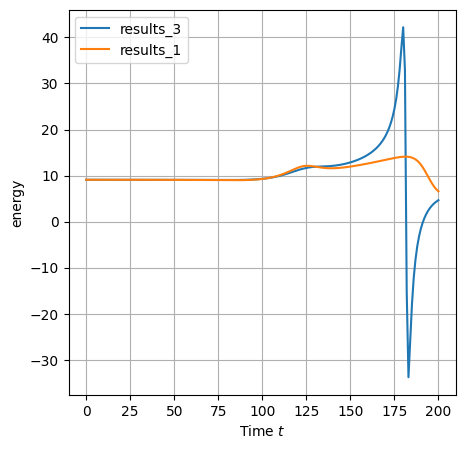

In [25]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5,5))

#axs1.plot( np.real(results_N) , label="case 1 real")

#axs1.plot( results_1_conj , label="results_1_conj")
axs1.plot( results_3 , label="results_3")
#axs1.plot( results_3_conj , label="results_3_conj")
axs1.plot( results_1 , label="results_1")
#axs1.plot( np.real(esults_no_norm), label="esults_no_norm")

#axs1.plot( results_1_conj, label="results_1_conj")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.grid(True)
axs1.legend()

In [26]:
results_N2_abs = np.array([ 9.73777595+9.55531646e-16j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75530945+2.43445860e-01j,  9.7575785 +2.58648035e-01j,
        9.75998678+2.73842689e-01j,  9.76253451+2.89028799e-01j,
        9.76522188+3.04205326e-01j,  9.76804909+3.19371217e-01j,
        9.77101634+3.34525404e-01j,  9.7741238 +3.49666799e-01j,
        9.77737166+3.64794295e-01j,  9.78076005+3.79906761e-01j,
        9.78428914+3.95003041e-01j,  9.78795904+4.10081951e-01j,
        9.79176986+4.25142278e-01j,  9.79572168+4.40182773e-01j,
        9.79981456+4.55202152e-01j,  9.80404853+4.70199090e-01j,
        9.80842211+4.85365936e-01j,  9.81292541+5.00508752e-01j,
        9.81758568+5.15645159e-01j,  9.82240356+5.30777935e-01j,
        9.82737673+5.45907592e-01j,  9.83250326+5.61034326e-01j,
        9.83778157+5.76158283e-01j,  9.8432103 +5.91279590e-01j,
        9.84878821+6.06398361e-01j,  9.85451407+6.21514685e-01j,
        9.86038662+6.36628619e-01j,  9.86640452+6.51740181e-01j,
        9.8725663 +6.66849338e-01j,  9.87887038+6.81956001e-01j,
        9.885315  +6.97060016e-01j,  9.89185502+7.11905342e-01j,
        9.89870343+7.25835296e-01j,  9.90582197+7.39619200e-01j,
        9.91316181+7.53283737e-01j,  9.92069429+7.66827540e-01j,
        9.92840776+7.80245684e-01j,  9.93629553+7.93532099e-01j,
        9.94435274+8.06680043e-01j,  9.9525753 +8.19682252e-01j,
        9.96095936+8.32530998e-01j,  9.96950112+8.45218089e-01j,
        9.97819662+8.57734863e-01j,  9.98704165+8.70072154e-01j,
        9.9960317 +8.82220268e-01j, 10.00516186+8.94168933e-01j,
       10.01442674+9.05907265e-01j, 10.02325973+9.17778866e-01j,
       10.03193326+9.30661224e-01j, 10.04059594+9.43530139e-01j,
       10.04931249+9.56325513e-01j, 10.05809837+9.69018951e-01j,
       10.06695782+9.81593348e-01j, 10.07589121+9.94036147e-01j,
       10.0848971 +1.00633690e+00j, 10.09397298+1.01848623e+00j,
       10.10311561+1.03047530e+00j, 10.11232122+1.04229553e+00j,
       10.12158563+1.05393844e+00j, 10.13090429+1.06539553e+00j,
       10.14027239+1.07665823e+00j, 10.14968492+1.08771787e+00j,
       10.15893394+1.09871878e+00j, 10.16757305+1.10951465e+00j,
       10.17620351+1.12010735e+00j, 10.18481278+1.13050135e+00j,
       10.19339223+1.14069129e+00j, 10.20193461+1.15067121e+00j,
       10.21043328+1.16043470e+00j, 10.21888231+1.16997489e+00j,
       10.22727661+1.17928444e+00j, 10.23561222+1.18835551e+00j,
       10.24388659+1.19717983e+00j, 10.252099  +1.20574867e+00j,
       10.26025086+1.21405283e+00j, 10.26834624+1.22208265e+00j,
       10.27639238+1.22982803e+00j, 10.28440028+1.23727840e+00j,
       10.29161819+1.24260405e+00j, 10.29877558+1.24745150e+00j,
       10.305856  +1.25179136e+00j, 10.31289131+1.25555298e+00j,
       10.31990969+1.25868041e+00j, 10.32694254+1.26111715e+00j,
       10.33402684+1.26280307e+00j, 10.3412065 +1.26367313e+00j,
       10.34853353+1.26365648e+00j, 10.35606919+1.26267562e+00j,
       10.3638852 +1.26064571e+00j, 10.37206505+1.25747374e+00j,
       10.38070545+1.25305776e+00j, 10.38991784+1.24728593e+00j,
       10.39983002+1.24003558e+00j, 10.41058798+1.23117208e+00j,
       10.42235779+1.22054756e+00j, 10.43532756+1.20799942e+00j,
       10.44970955+1.19334848e+00j, 10.46574235+1.17639680e+00j,
       10.48369304+1.15692490e+00j, 10.50385932+1.13468824e+00j,
       10.52657156+1.10941273e+00j, 10.55219458+1.08078892e+00j,
       10.58112897+1.04846442e+00j, 10.6138118 +1.01203407e+00j,
       10.6507161 +9.71027049e-01j, 10.69234875+9.24890117e-01j,
       10.73924559+8.72965830e-01j, 10.79196249+8.14464344e-01j,
       10.85105999+7.48427240e-01j, 10.91707822+6.73681573e-01j,
       10.99049684+5.88782470e-01j, 11.07167196+4.91943216e-01j,
       11.16073836+3.80953561e-01j, 11.25745989+2.53091117e-01j,
       11.36100428+1.05039153e-01j, 11.46961223-6.71598205e-02j,
       11.58012865-2.68056817e-01j, 11.68737701-5.02551865e-01j,
       11.78340853-7.75285715e-01j, 11.85678221-1.08944168e+00j,
       11.89226888-1.44474527e+00j, 11.87170206-1.83468817e+00j,
       11.77690502-2.24366107e+00j, 11.59516989-2.64572459e+00j,
       11.32608105-3.00740123e+00j, 10.98609406-3.29559205e+00j,
       10.60672378-3.48800559e+00j, 10.22573001-3.58026976e+00j,
        9.8759774 -3.58541201e+00j,  9.57809647-3.52689431e+00j,
        9.33938964-3.43017122e+00j,  9.15710943-3.31683109e+00j,
        9.02293193-3.20229851e+00j,  8.92657909-3.09603082e+00j,
        8.85802746-3.00279601e+00j,  8.8085551 -2.92409909e+00j,
        8.77107251-2.85935598e+00j,  8.74009763-2.80673509e+00j,
        8.7115935 -2.76372078e+00j,  8.68277756-2.72748388e+00j,
        8.65194432-2.69513259e+00j,  8.618308  -2.66389472e+00j,
        8.58185736-2.63125992e+00j,  8.54321162-2.59509400e+00j,
        8.50347004-2.55372584e+00j,  8.46405398-2.50600185e+00j,
        8.42654693-2.45130264e+00j,  8.39254285-2.38951959e+00j,
        8.36351476-2.32099466e+00j,  8.34071365-2.24643203e+00j,
        8.32510372-2.16679378e+00j,  8.31733429-2.08319260e+00j,
        8.31774412-1.99679314e+00j,  8.32639043-1.90873004e+00j,
        8.34309368-1.82004667e+00j,  8.36748962-1.73165524e+00j,
        8.39908157-1.64431599e+00j,  8.43728823-1.55863183e+00j,
        8.48148411-1.47505437e+00j,  8.53103159-1.39389723e+00j,
        8.58530462-1.31535336e+00j,  8.64370501-1.23951400e+00j,
        8.70567249-1.16638723e+00j,  8.77068987-1.09591533e+00j,
        8.83828451-1.02799012e+00j,  8.90802713-9.62466225e-01j,
        8.97952896-8.99172219e-01j,  9.05243768-8.37919823e-01j,
        9.12643292-7.78511425e-01j,  9.20122139-7.20746180e-01j,
        9.2765321 -6.64424955e-01j,  9.35211179-6.09354389e-01j,
        9.42772056-5.55350261e-01j,  9.50312789-5.02240381e-01j,
        9.57810896-4.49867160e-01j,  9.65244138-3.98089982e-01j,
        9.72590227-3.46787515e-01j,  9.79826561-2.95860014e-01j,
        9.86930008-2.45231718e-01j,  9.93876702-1.94853368e-01j,
       10.00641895-1.44704889e-01j, 10.0719982 -9.47982381e-02j,
       10.13523611-4.51804142e-02j, 10.19585243+4.06342328e-03j,
       10.25355527+5.28067873e-02j])

In [27]:
# NO NORM - start with normalized state
results_N = np.array([ 9.73777595+1.81089812e-16j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75530945+2.43445860e-01j,  9.7575785 +2.58648035e-01j,
        9.75998678+2.73842689e-01j,  9.76253451+2.89028799e-01j,
        9.76522188+3.04205326e-01j,  9.76804909+3.19371217e-01j,
        9.77101634+3.34525404e-01j,  9.7741238 +3.49666799e-01j,
        9.77737166+3.64794295e-01j,  9.78076005+3.79906761e-01j,
        9.78428914+3.95003041e-01j,  9.78795904+4.10081951e-01j,
        9.79176986+4.25142278e-01j,  9.79572168+4.40182773e-01j,
        9.79981456+4.55202152e-01j,  9.80404853+4.70199090e-01j,
        9.80865015+4.85600803e-01j,  9.81341826+5.01116691e-01j,
        9.81833556+5.16647402e-01j,  9.82340241+5.32187759e-01j,
        9.82861845+5.47736126e-01j,  9.83398308+5.63291658e-01j,
        9.83949552+5.78853774e-01j,  9.84515486+5.94421989e-01j,
        9.85096008+6.09995849e-01j,  9.85691001+6.25574890e-01j,
        9.86300337+6.41158626e-01j,  9.86923874+6.56746529e-01j,
        9.87561457+6.72338021e-01j,  9.88212915+6.87932464e-01j,
        9.88878062+7.03529152e-01j,  9.89527013+7.18910152e-01j,
        9.9018241 +7.33797134e-01j,  9.90855355+7.48614426e-01j,
        9.91544004+7.63399793e-01j,  9.92247997+7.78160894e-01j,
        9.92967185+7.92899433e-01j,  9.93701494+8.07615044e-01j,
        9.94450883+8.22306368e-01j,  9.95215332+8.36971435e-01j,
        9.95994838+8.51607813e-01j,  9.96789415+8.66212671e-01j,
        9.97599089+8.80782801e-01j,  9.98423906+8.95314613e-01j,
        9.99263926+9.09804124e-01j, 10.00119232+9.24246943e-01j,
       10.00989927+9.38638244e-01j, 10.01965698+9.51497902e-01j,
       10.02976305+9.62959059e-01j, 10.040144  +9.73827765e-01j,
       10.05080694+9.84204825e-01j, 10.06176194+9.94108090e-01j,
       10.07301792+1.00352984e+00j, 10.08458221+1.01245023e+00j,
       10.09646058+1.02084193e+00j, 10.10865715+1.02867205e+00j,
       10.12117425+1.03590303e+00j, 10.13401213+1.04249305e+00j,
       10.14716852+1.04839623e+00j, 10.1606381 +1.05356265e+00j,
       10.17441189+1.05793839e+00j, 10.18847652+1.06146551e+00j,
       10.20166729+1.06623082e+00j, 10.21308144+1.07408811e+00j,
       10.22457794+1.08183042e+00j, 10.23611862+1.08946982e+00j,
       10.24766347+1.09693616e+00j, 10.25919323+1.10414636e+00j,
       10.27070139+1.11103306e+00j, 10.28218626+1.11754638e+00j,
       10.29364682+1.12364853e+00j, 10.30508145+1.12930909e+00j,
       10.31648769+1.13450189e+00j, 10.32786256+1.13920335e+00j,
       10.33920297+1.14339145e+00j, 10.35050618+1.14704534e+00j,
       10.36177032+1.15014512e+00j, 10.37299494+1.15267180e+00j,
       10.38338049+1.15343604e+00j, 10.39372203+1.15331392e+00j,
       10.40413483+1.15218825e+00j, 10.41457896+1.15002742e+00j,
       10.42504698+1.14678062e+00j, 10.43553769+1.14238825e+00j,
       10.44605199+1.13678499e+00j, 10.45659188+1.12990132e+00j,
       10.46716018+1.12166443e+00j, 10.47776052+1.11199899e+00j,
       10.48839726+1.10082793e+00j, 10.49907556+1.08807329e+00j,
       10.50980137+1.07365718e+00j, 10.52058156+1.05750296e+00j,
       10.53142393+1.03953657e+00j, 10.53965772+1.01954675e+00j,
       10.54852096+9.98092165e-01j, 10.55820855+9.73700158e-01j,
       10.56807979+9.46544476e-01j, 10.57796897+9.16476315e-01j,
       10.5877563 +8.83279542e-01j, 10.59731175+8.46704953e-01j,
       10.60647307+8.06478256e-01j, 10.61502963+7.62303567e-01j,
       10.62270601+7.13866980e-01j, 10.6291438 +6.60842121e-01j,
       10.63388025+6.02899236e-01j, 10.63632396+5.39719633e-01j,
       10.63572734+4.71017752e-01j, 10.63115719+3.96573797e-01j,
       10.62146547+3.16280412e-01j, 10.60526441+2.30207343e-01j,
       10.58091301+1.38687741e-01j, 10.54652543+4.24283231e-02j,
       10.50001617-5.73581993e-02j, 10.43920064-1.58807156e-01j,
       10.36197086-2.59262710e-01j, 10.26656044-3.55181223e-01j,
       10.15189673-4.42129293e-01j, 10.01800674-5.14937474e-01j,
        9.8664013 -5.68060039e-01j,  9.70032122-5.96148707e-01j,
        9.52471741-5.94773730e-01j,  9.34587908-5.61141534e-01j,
        9.17072604-4.94609143e-01j,  9.00590717-3.96825082e-01j,
        8.85693183-2.71438752e-01j,  8.72755364-1.23465959e-01j,
        8.61952735+4.14976031e-02j,  8.5327272 +2.18007494e-01j,
        8.46551526+4.01302256e-01j,  8.41521475+5.87586002e-01j,
        8.37856684+7.74089766e-01j,  8.35209971+9.58978824e-01j,
        8.33238591+1.14117765e+00j,  8.31619684+1.32016887e+00j,
        8.30057747+1.49580178e+00j,  8.28286764+1.66812783e+00j,
        8.26069256+1.83726843e+00j,  8.23193926+2.00331337e+00j,
        8.19473058+2.16624542e+00j,  8.14740348+2.32588603e+00j,
        8.08849567+2.48185783e+00j,  8.01674217+2.63356088e+00j,
        7.93108213+2.78016061e+00j,  7.83067504+2.92058693e+00j,
        7.71492494+3.05354424e+00j,  7.58351022+3.17753304e+00j,
        7.43641602+3.29088381e+00j,  7.2739659 +3.39180336e+00j,
        7.0968484 +3.47843370e+00j,  6.90613444+3.54892190e+00j,
        6.70328131+3.60149886e+00j,  6.49011955+3.63456279e+00j,
        6.26882053+3.64676281e+00j,  6.04184365+3.63707642e+00j,
        5.8118647 +3.60487491e+00j,  5.58168843+3.54997083e+00j,
        5.35415085+3.47264306e+00j,  5.13201784+3.37363693e+00j,
        4.9178874 +3.25413916e+00j,  4.71410244+3.11572975e+00j,
        4.52268013+2.96031542e+00j,  4.34526151+2.79005017e+00j,
        4.18308334+2.60724978e+00j,  4.0369717 +2.41430659e+00j,
        3.90735496+2.21361024e+00j,  3.79429268+2.00747851e+00j,
        3.6975159 +1.79810115e+00j,  3.6164744 +1.58749767e+00j,
        3.55038687+1.37748888e+00j,  3.49829035+1.16968109e+00j,
        3.45908646+9.65460920e-01j,  3.43158258+7.65998512e-01j,
        3.41452703+5.72256946e-01j,  3.40663798+3.85005632e-01j,
        3.40662621+2.04835882e-01j,  3.41321242+3.21771484e-02j,
        3.42513972-1.32687231e-01j,  3.44118226-2.89605576e-01j,
        3.46015085-4.38545233e-01j,  3.4808965 -5.79582031e-01j,
        3.50231242-7.12891943e-01j,  3.52333546-8.38744905e-01j,
        3.54294726-9.57500702e-01j,  3.56017575-1.06960678e+00j,
        3.57409743-1.17559786e+00j])

In [28]:
# T /= norm_1.conj()
results_N1 = np.array([ 9.73777595+1.81089812e-16j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75530945+2.43445860e-01j,  9.7575785 +2.58648035e-01j,
        9.75998678+2.73842689e-01j,  9.76253451+2.89028799e-01j,
        9.76522188+3.04205326e-01j,  9.76804909+3.19371217e-01j,
        9.77101634+3.34525404e-01j,  9.7741238 +3.49666799e-01j,
        9.77737166+3.64794295e-01j,  9.78076005+3.79906761e-01j,
        9.78428914+3.95003041e-01j,  9.78795904+4.10081951e-01j,
        9.79176986+4.25142278e-01j,  9.79572168+4.40182773e-01j,
        9.79981456+4.55202152e-01j,  9.80404853+4.70199090e-01j,
        9.80865015+4.85600803e-01j,  9.81341826+5.01116691e-01j,
        9.81833556+5.16647402e-01j,  9.82340241+5.32187759e-01j,
        9.82861845+5.47736126e-01j,  9.83398308+5.63291658e-01j,
        9.83949552+5.78853774e-01j,  9.84515486+5.94421989e-01j,
        9.85096008+6.09995849e-01j,  9.85691001+6.25574890e-01j,
        9.86300337+6.41158626e-01j,  9.86923874+6.56746529e-01j,
        9.87561457+6.72338021e-01j,  9.88212915+6.87932464e-01j,
        9.88878062+7.03529152e-01j,  9.89527013+7.18910152e-01j,
        9.9018241 +7.33797134e-01j,  9.90855355+7.48614426e-01j,
        9.91544004+7.63399793e-01j,  9.92247997+7.78160894e-01j,
        9.92967185+7.92899433e-01j,  9.93701494+8.07615044e-01j,
        9.94450883+8.22306368e-01j,  9.95215332+8.36971435e-01j,
        9.95994838+8.51607813e-01j,  9.96789415+8.66212671e-01j,
        9.97599089+8.80782801e-01j,  9.98423906+8.95314613e-01j,
        9.99263926+9.09804124e-01j, 10.00119232+9.24246943e-01j,
       10.00989927+9.38638244e-01j, 10.01965698+9.51497902e-01j,
       10.02976305+9.62959059e-01j, 10.040144  +9.73827765e-01j,
       10.05080694+9.84204825e-01j, 10.06176194+9.94108090e-01j,
       10.07301792+1.00352984e+00j, 10.08458221+1.01245023e+00j,
       10.09646058+1.02084193e+00j, 10.10865715+1.02867205e+00j,
       10.12117425+1.03590303e+00j, 10.13401213+1.04249305e+00j,
       10.14716852+1.04839623e+00j, 10.1606381 +1.05356265e+00j,
       10.17441189+1.05793839e+00j, 10.18847652+1.06146551e+00j,
       10.20166729+1.06623082e+00j, 10.21308144+1.07408811e+00j,
       10.22457794+1.08183042e+00j, 10.23611862+1.08946982e+00j,
       10.24766347+1.09693616e+00j, 10.25919323+1.10414636e+00j,
       10.27070139+1.11103306e+00j, 10.28218626+1.11754638e+00j,
       10.29364682+1.12364853e+00j, 10.30508145+1.12930909e+00j,
       10.31648769+1.13450189e+00j, 10.32786256+1.13920335e+00j,
       10.33920297+1.14339145e+00j, 10.35050618+1.14704534e+00j,
       10.36177032+1.15014512e+00j, 10.37299494+1.15267180e+00j,
       10.38338049+1.15343604e+00j, 10.39372203+1.15331392e+00j,
       10.40413483+1.15218825e+00j, 10.41457896+1.15002742e+00j,
       10.42504698+1.14678062e+00j, 10.43553769+1.14238825e+00j,
       10.44605199+1.13678499e+00j, 10.45659188+1.12990132e+00j,
       10.46716018+1.12166443e+00j, 10.47776052+1.11199899e+00j,
       10.48839726+1.10082793e+00j, 10.49907556+1.08807329e+00j,
       10.50980137+1.07365718e+00j, 10.52058156+1.05750296e+00j,
       10.53142393+1.03953657e+00j, 10.53965772+1.01954675e+00j,
       10.54852096+9.98092165e-01j, 10.55820855+9.73700158e-01j,
       10.56807979+9.46544476e-01j, 10.57796897+9.16476315e-01j,
       10.5877563 +8.83279542e-01j, 10.59731175+8.46704953e-01j,
       10.60647307+8.06478256e-01j, 10.61502963+7.62303567e-01j,
       10.62270601+7.13866980e-01j, 10.6291438 +6.60842121e-01j,
       10.63388025+6.02899236e-01j, 10.63632396+5.39719633e-01j,
       10.63572734+4.71017752e-01j, 10.63115719+3.96573797e-01j,
       10.62146547+3.16280412e-01j, 10.60526441+2.30207343e-01j,
       10.58091301+1.38687741e-01j, 10.54652543+4.24283231e-02j,
       10.50001617-5.73581993e-02j, 10.43920064-1.58807156e-01j,
       10.36197086-2.59262710e-01j, 10.26656044-3.55181223e-01j,
       10.15189673-4.42129293e-01j, 10.01800674-5.14937474e-01j,
        9.8664013 -5.68060039e-01j,  9.70032122-5.96148707e-01j,
        9.52471741-5.94773730e-01j,  9.34587908-5.61141534e-01j,
        9.17072604-4.94609143e-01j,  9.00590717-3.96825082e-01j,
        8.85693183-2.71438752e-01j,  8.72755364-1.23465959e-01j,
        8.61952735+4.14976031e-02j,  8.5327272 +2.18007494e-01j,
        8.46551526+4.01302256e-01j,  8.41521475+5.87586002e-01j,
        8.37856684+7.74089766e-01j,  8.35209971+9.58978824e-01j,
        8.33238591+1.14117765e+00j,  8.31619684+1.32016887e+00j,
        8.30057747+1.49580178e+00j,  8.28286764+1.66812783e+00j,
        8.26069256+1.83726843e+00j,  8.23193926+2.00331337e+00j,
        8.19473058+2.16624542e+00j,  8.14740348+2.32588603e+00j,
        8.08849567+2.48185783e+00j,  8.01674217+2.63356088e+00j,
        7.93108213+2.78016061e+00j,  7.83067504+2.92058693e+00j,
        7.71492494+3.05354424e+00j,  7.58351022+3.17753304e+00j,
        7.43641602+3.29088381e+00j,  7.2739659 +3.39180336e+00j,
        7.0968484 +3.47843370e+00j,  6.90613444+3.54892190e+00j,
        6.70328131+3.60149886e+00j,  6.49011955+3.63456279e+00j,
        6.26882053+3.64676281e+00j,  6.04184365+3.63707642e+00j,
        5.8118647 +3.60487491e+00j,  5.58168843+3.54997083e+00j,
        5.35415085+3.47264306e+00j,  5.13201784+3.37363693e+00j,
        4.9178874 +3.25413916e+00j,  4.71410244+3.11572975e+00j,
        4.52268013+2.96031542e+00j,  4.34526151+2.79005017e+00j,
        4.18308334+2.60724978e+00j,  4.0369717 +2.41430659e+00j,
        3.90735496+2.21361024e+00j,  3.79429268+2.00747851e+00j,
        3.6975159 +1.79810115e+00j,  3.6164744 +1.58749767e+00j,
        3.55038687+1.37748888e+00j,  3.49829035+1.16968109e+00j,
        3.45908646+9.65460920e-01j,  3.43158258+7.65998512e-01j,
        3.41452703+5.72256946e-01j,  3.40663798+3.85005632e-01j,
        3.40662621+2.04835882e-01j,  3.41321242+3.21771484e-02j,
        3.42513972-1.32687231e-01j,  3.44118226-2.89605576e-01j,
        3.46015085-4.38545233e-01j,  3.4808965 -5.79582031e-01j,
        3.50231242-7.12891943e-01j,  3.52333546-8.38744905e-01j,
        3.54294726-9.57500702e-01j,  3.56017575-1.06960678e+00j,
        3.57409743-1.17559786e+00j])

In [29]:
# T /= norm_1
results_N2 = np.array([ 9.73777595-6.37453433e-16j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75530945+2.43445860e-01j,  9.7575785 +2.58648035e-01j,
        9.75998678+2.73842689e-01j,  9.76253451+2.89028799e-01j,
        9.76522188+3.04205326e-01j,  9.76804909+3.19371217e-01j,
        9.77101634+3.34525404e-01j,  9.7741238 +3.49666799e-01j,
        9.77737166+3.64794295e-01j,  9.78076005+3.79906761e-01j,
        9.78428914+3.95003041e-01j,  9.78795904+4.10081951e-01j,
        9.79176986+4.25142278e-01j,  9.79572168+4.40182773e-01j,
        9.79981456+4.55202152e-01j,  9.80404853+4.70199090e-01j,
        9.80885258+4.85628151e-01j,  9.81383926+5.01015052e-01j,
        9.81899331+5.16413745e-01j,  9.82431118+5.31828356e-01j,
        9.8297909 +5.47260758e-01j,  9.83543097+5.62712304e-01j,
        9.84122998+5.78184176e-01j,  9.84718654+5.93677483e-01j,
        9.85329917+6.09193301e-01j,  9.85956628+6.24732686e-01j,
        9.86598615+6.40296677e-01j,  9.87255688+6.55886295e-01j,
        9.87927639+6.71502543e-01j,  9.88614238+6.87146398e-01j,
        9.89315233+7.02818808e-01j,  9.89994457+7.18271092e-01j,
        9.90625821+7.32933825e-01j,  9.91261706+7.47479123e-01j,
        9.9190797 +7.61965801e-01j,  9.92566509+7.76407979e-01j,
        9.93238215+7.90811343e-01j,  9.93923534+8.05178379e-01j,
        9.94622698+8.19509898e-01j,  9.95335821+8.33805656e-01j,
        9.96062948+8.48064658e-01j,  9.96804083+8.62285318e-01j,
        9.97559199+8.76465542e-01j,  9.98328248+8.90602769e-01j,
        9.99111169+9.04693991e-01j,  9.99907884+9.18735748e-01j,
       10.00718306+9.32724117e-01j, 10.01548527+9.45788526e-01j,
       10.02415874+9.58821720e-01j, 10.03302255+9.71747297e-01j,
       10.04206026+9.84537870e-01j, 10.05126718+9.97175809e-01j,
       10.06064233+1.00964622e+00j, 10.07018618+1.02193514e+00j,
       10.07989977+1.03402882e+00j, 10.08978425+1.04591349e+00j,
       10.09984058+1.05757527e+00j, 10.11006933+1.06900014e+00j,
       10.12047055+1.08017395e+00j, 10.1310436 +1.09108253e+00j,
       10.1417871 +1.10171175e+00j, 10.15269884+1.11204756e+00j,
       10.16353196+1.12145750e+00j, 10.17428438+1.13265885e+00j,
       10.18495277+1.14361188e+00j, 10.19583217+1.15412083e+00j,
       10.20695477+1.16421059e+00j, 10.21833633+1.17388264e+00j,
       10.22999352+1.18312777e+00j, 10.24194593+1.19193061e+00j,
       10.25421641+1.20027106e+00j, 10.26683127+1.20812468e+00j,
       10.27982061+1.21546276e+00j, 10.29321866+1.22225223e+00j,
       10.30706438+1.22845550e+00j, 10.3214021 +1.23403026e+00j,
       10.3362822 +1.23892914e+00j, 10.35176198+1.24309936e+00j,
       10.36601523+1.24714090e+00j, 10.38031983+1.25121632e+00j,
       10.39509892+1.25477832e+00j, 10.4103865 +1.25771946e+00j,
       10.4262377 +1.25996756e+00j, 10.44272021+1.26145961e+00j,
       10.45991385+1.26213457e+00j, 10.47791164+1.26193042e+00j,
       10.49682141+1.26078266e+00j, 10.51676777+1.25862324e+00j,
       10.53789451+1.25537963e+00j, 10.56036721+1.25097382e+00j,
       10.58437637+1.24532120e+00j, 10.61014096+1.23832907e+00j,
       10.63791243+1.22989477e+00j, 10.66797939+1.21990319e+00j,
       10.70067293+1.20822353e+00j, 10.73637271+1.19470482e+00j,
       10.77551398+1.17917011e+00j, 10.81859555+1.16140849e+00j,
       10.86618897+1.14116449e+00j, 10.9189488 +1.11812377e+00j,
       10.97762419+1.09189381e+00j, 11.04307141+1.06197788e+00j,
       11.11626709+1.02773989e+00j, 11.19832113+9.88356799e-01j,
       11.29048736+9.42754196e-01j, 11.39416849+8.89519123e-01j,
       11.51090902+8.26782271e-01j, 11.64236501+7.52059649e-01j,
       11.7902315 +6.62041925e-01j, 11.95609526+5.52319514e-01j,
       12.14115918+4.17036359e-01j, 12.34575274+2.48482565e-01j,
       12.56849907+3.66804621e-02j, 12.80496357-2.30882767e-01j,
       13.04559967-5.69029327e-01j, 13.27294353-9.93501990e-01j,
       13.45851589-1.51734642e+00j, 13.56106903-2.14390547e+00j,
       13.52961321-2.85646683e+00j, 13.31550622-3.60836269e+00j,
       12.8940126 -4.32262649e+00j, 12.2852423 -4.91026236e+00j,
       11.55648463-5.30301997e+00j, 10.79848987-5.47938904e+00j,
       10.09152867-5.46515547e+00j,  9.48430791-5.31265148e+00j,
        8.99296633-5.07723368e+00j,  8.61158428-4.80341744e+00j,
        8.32381284-4.52128368e+00j,  8.11082953-4.24852430e+00j,
        7.95537232-3.99408613e+00j,  7.84318167-3.76143908e+00j,
        7.76311781-3.55092545e+00j,  7.70674659-3.36126537e+00j,
        7.6677945 -3.19045283e+00j,  7.64164111-3.03625830e+00j,
        7.62490207-2.89649337e+00j,  7.61510649-2.76913783e+00j,
        7.61045484-2.65239005e+00j,  7.60964037-2.54467667e+00j,
        7.6117182 -2.44464177e+00j,  7.61600963-2.35112697e+00j,
        7.62203213-2.26314852e+00j,  7.62944788-2.17987453e+00j,
        7.63802588-2.10060383e+00j,  7.64761384-2.02474701e+00j,
        7.65811723-1.95180983e+00j,  7.66948363-1.88137887e+00j,
        7.68169094-1.81310909e+00j,  7.69473845-1.74671331e+00j,
        7.70864014-1.68195305e+00j,  7.72341956-1.61863077e+00j,
        7.73910596-1.55658313e+00j,  7.75573137-1.49567522e+00j,
        7.77332838-1.43579556e+00j,  7.79192852-1.37685174e+00j,
        7.81156103-1.31876656e+00j,  7.83225194-1.26147479e+00j,
        7.85402351-1.20492010e+00j,  7.87689372-1.14905252e+00j,
        7.90087601-1.09382608e+00j,  7.92597913-1.03919672e+00j,
        7.95220696-9.85120379e-01j,  7.97955855-9.31551348e-01j,
        8.00802803-8.78440694e-01j,  8.03760464-8.25734887e-01j,
        8.06827269-7.73374542e-01j,  8.10001155-7.21293287e-01j,
        8.13279551-6.69416750e-01j,  8.16659371-6.17661666e-01j,
        8.20136983-5.65935087e-01j,  8.23708185-5.14133718e-01j,
        8.27368155-4.62143365e-01j,  8.31111398-4.09838504e-01j,
        8.34931668-3.57081987e-01j,  8.38821875-3.03724879e-01j,
        8.42773975-2.49606458e-01j,  8.4677883 -1.94554377e-01j,
        8.50826047-1.38385023e-01j,  8.54903788-8.09040919e-02j,
        8.58998557-2.19074291e-02j,  8.63094952+3.88178357e-02j,
        8.67175393+1.01491787e-01j,  8.71219822+1.66339790e-01j,
        8.75205388+2.33590041e-01j])

In [30]:
# T /= norm
results_N3 = np.array([ 9.73777595+3.62179625e-16j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75531203+2.43471582e-01j,  9.75756767+2.58727136e-01j,
        9.75995851+2.73981540e-01j,  9.76248584+2.89235897e-01j,
        9.76514993+3.04490219e-01j,  9.76795088+3.19744307e-01j,
        9.77088865+3.34997893e-01j,  9.77396319+3.50250668e-01j,
        9.77717438+3.65502301e-01j,  9.78052208+3.80752439e-01j,
        9.7840061 +3.96000711e-01j,  9.78762624+4.11246725e-01j,
        9.79138224+4.26490067e-01j,  9.79527381+4.41730301e-01j,
        9.79930063+4.56966962e-01j,  9.80346233+4.72199559e-01j,
        9.80782108+4.87795004e-01j,  9.81241486+5.03364518e-01j,
        9.81716424+5.18940719e-01j,  9.82206044+5.34528101e-01j,
        9.82709993+5.50128293e-01j,  9.83228054+5.65742097e-01j,
        9.83760057+5.81369953e-01j,  9.84305852+5.97012100e-01j,
        9.84865291+6.12668648e-01j,  9.85438226+6.28339601e-01j,
        9.86024503+6.44024881e-01j,  9.86623958+6.59724329e-01j,
        9.87236418+6.75437714e-01j,  9.87861695+6.91164730e-01j,
        9.88499589+7.06904997e-01j,  9.89143864+7.22264809e-01j,
        9.89817838+7.37011660e-01j,  9.90514507+7.51679528e-01j,
        9.91231922+7.66300759e-01j,  9.91970122+7.80881738e-01j,
        9.92729352+7.95423271e-01j,  9.93509909+8.09924251e-01j,
        9.9431212 +8.24382741e-01j,  9.95136333+8.38796340e-01j,
        9.95982917+8.53162308e-01j,  9.96852257+8.67477600e-01j,
        9.97744756+8.81738851e-01j,  9.98660831+8.95942352e-01j,
        9.99600915+9.10084001e-01j, 10.00565451+9.24159265e-01j,
       10.01554896+9.38163120e-01j, 10.0254428 +9.51952948e-01j,
       10.03555415+9.65543981e-01j, 10.04591764+9.78990719e-01j,
       10.05654036+9.92287937e-01j, 10.06742637+1.00542741e+00j,
       10.07857892+1.01839934e+00j, 10.09000094+1.03119260e+00j,
       10.10169524+1.04379483e+00j, 10.11366455+1.05619242e+00j,
       10.12591158+1.06837047e+00j, 10.13843903+1.08031279e+00j,
       10.15124959+1.09200178e+00j, 10.16434599+1.10341837e+00j,
       10.17773098+1.11454192e+00j, 10.19140735+1.12535016e+00j,
       10.20682439+1.13401820e+00j, 10.22175068+1.14060159e+00j,
       10.23597333+1.14834691e+00j, 10.2502768 +1.15613246e+00j,
       10.26481934+1.16366221e+00j, 10.27967123+1.17080235e+00j,
       10.29488   +1.17746415e+00j, 10.31048661+1.18357407e+00j,
       10.32653145+1.18906312e+00j, 10.34305723+1.19386205e+00j,
       10.36011075+1.19789869e+00j, 10.37774419+1.20109613e+00j,
       10.39601633+1.20337118e+00j, 10.4149936 +1.20463304e+00j,
       10.43475134+1.20478175e+00j, 10.45537494+1.20370660e+00j,
       10.47124542+1.20446719e+00j, 10.48716375+1.20326030e+00j,
       10.50304219+1.20065150e+00j, 10.51891104+1.19671810e+00j,
       10.53480125+1.19144201e+00j, 10.55073704+1.18477681e+00j,
       10.56674171+1.17666322e+00j, 10.5828409 +1.16703475e+00j,
       10.59906471+1.15582025e+00j, 10.61544944+1.14294540e+00j,
       10.63203914+1.12833377e+00j, 10.64888727+1.11190763e+00j,
       10.6660583 +1.09358875e+00j, 10.6836295 +1.07329914e+00j,
       10.70169278+1.05096180e+00j, 10.72046588+1.02855689e+00j,
       10.74081552+1.00752043e+00j, 10.7627355 +9.85225952e-01j,
       10.78639561+9.61271127e-01j, 10.81205995+9.35574210e-01j,
       10.84004464+9.08071079e-01j, 10.87072321+8.78699922e-01j,
       10.90453454+8.47396934e-01j, 10.94199362+8.14093058e-01j,
       10.98370524+7.78710096e-01j, 11.03038137+7.41155493e-01j,
       11.08286311+7.01315088e-01j, 11.14214873+6.59042951e-01j,
       11.20942995+6.14147015e-01j, 11.28613912+5.66368579e-01j,
       11.37401178+5.15352750e-01j, 11.47517027+4.60605244e-01j,
       11.59223735+4.01428244e-01j, 11.7284925 +3.36823385e-01j,
       11.88809053+2.65341881e-01j, 12.07637174+1.84847274e-01j,
       12.30030892+9.21293681e-02j, 12.56916108-1.77440235e-02j,
       12.89544036-1.52554947e-01j, 13.29634698-3.24978215e-01j,
       13.79586279-5.56453250e-01j, 14.42758203-8.84900119e-01j,
       15.23748396-1.38093551e+00j, 16.28147778-2.18363897e+00j,
       17.59233179-3.58068313e+00j, 19.00132073-6.16451398e+00j,
       19.40466731-1.08533733e+01j, 15.53219521-1.68564286e+01j,
        7.21786125-1.78253010e+01j,  2.2806041 -1.32350613e+01j,
        1.46013479-8.99098673e+00j,  2.02099906-6.36166360e+00j,
        2.81282377-4.79825052e+00j,  3.54130269-3.83303089e+00j,
        4.15620709-3.20739869e+00j,  4.66636137-2.78350130e+00j,
        5.09117546-2.48530153e+00j,  5.44877818-2.26880873e+00j,
        5.75378683-2.10735435e+00j,  6.01750303-1.98407758e+00j,
        6.24858391-1.88792156e+00j,  6.4536828 -1.81140504e+00j,
        6.63795662-1.74933075e+00j,  6.80544462-1.69800876e+00j,
        6.9593453 -1.65477409e+00j,  7.10221802-1.61767807e+00j,
        7.23612988-1.58528580e+00j,  7.36276318-1.55653994e+00j,
        7.48349417-1.53066701e+00j,  7.59945097-1.50711152e+00j,
        7.71155604-1.48548827e+00j,  7.82055732-1.46554680e+00j,
        7.92705102-1.44714382e+00j,  8.03149839-1.43022066e+00j,
        8.13423833-1.41478398e+00j,  8.23549748-1.40088832e+00j,
        8.33539899-1.38861986e+00j,  8.43397117-1.37808098e+00j,
        8.53115684-1.36937571e+00j,  8.62682404-1.36259629e+00j,
        8.72077828-1.35781151e+00j,  8.81277646-1.35505727e+00j,
        8.90254192-1.35433007e+00j,  8.98978015-1.35558365e+00j,
        9.07419409-1.35872925e+00j,  9.15549839-1.36363905e+00j,
        9.23343153-1.37015253e+00j,  9.30776528-1.37808505e+00j,
        9.37831104-1.38723773e+00j,  9.44492301-1.39740770e+00j,
        9.50749827-1.40839805e+00j,  9.56597437-1.42002657e+00j,
        9.62032479-1.43213290e+00j,  9.6705531 -1.44458386e+00j,
        9.7166863 -1.45727673e+00j,  9.75876798-1.47014080e+00j,
        9.79685172-1.48313716e+00j,  9.830995  -1.49625721e+00j,
        9.86125399-1.50952002e+00j,  9.88767909-1.52296899e+00j,
        9.91031154-1.53666785e+00j,  9.92918079-1.55069646e+00j,
        9.94430285-1.56514630e+00j,  9.95567931-1.58011602e+00j,
        9.96329712-1.59570699e+00j,  9.96712908-1.61201893e+00j,
        9.96713478-1.62914569e+00j])

In [31]:
# T /= norm.conj() 
results_N4 = np.array([ 9.73777595+1.00376462e-15j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75530945+2.43445860e-01j,  9.7575785 +2.58648035e-01j,
        9.75998678+2.73842689e-01j,  9.76253451+2.89028799e-01j,
        9.76522188+3.04205326e-01j,  9.76804909+3.19371217e-01j,
        9.77101634+3.34525404e-01j,  9.7741238 +3.49666799e-01j,
        9.77737166+3.64794295e-01j,  9.78076005+3.79906761e-01j,
        9.78428914+3.95003041e-01j,  9.78795904+4.10081951e-01j,
        9.79176986+4.25142278e-01j,  9.79572168+4.40182773e-01j,
        9.79981456+4.55202152e-01j,  9.80404853+4.70199090e-01j,
        9.80862164+4.85835171e-01j,  9.81328042+5.01496431e-01j,
        9.81807512+5.17173405e-01j,  9.82301204+5.32868372e-01j,
        9.82809305+5.48582492e-01j,  9.83331868+5.64316545e-01j,
        9.83868883+5.80071139e-01j,  9.84420305+5.95846779e-01j,
        9.84986064+6.11643905e-01j,  9.85566069+6.27462904e-01j,
        9.8616021 +6.43304119e-01j,  9.86768361+6.59167849e-01j,
        9.87390377+6.75054350e-01j,  9.88026095+6.90963833e-01j,
        9.88675335+7.06896461e-01j,  9.8933    +7.22287819e-01j,
        9.89986076+7.36797572e-01j,  9.90643757+7.50985030e-01j,
        9.91308558+7.64983175e-01j,  9.91982118+7.78835493e-01j,
        9.92664968+7.92557053e-01j,  9.93357202+8.06153140e-01j,
        9.9405871 +8.19624597e-01j,  9.94769266+8.32969831e-01j,
        9.95488565+8.46185707e-01j,  9.96216251+8.59267989e-01j,
        9.96951917+8.72211571e-01j,  9.97695118+8.85010596e-01j,
        9.98445364+8.97658516e-01j,  9.99202126+9.10148117e-01j,
        9.9996483 +9.22471515e-01j, 10.00661379+9.34876444e-01j,
       10.01377355+9.47837281e-01j, 10.02104268+9.60889424e-01j,
       10.02840832+9.73946109e-01j, 10.03586038+9.86963203e-01j,
       10.0433912 +9.99916481e-01j, 10.05099462+1.01279057e+00j,
       10.05866528+1.02557444e+00j, 10.06639834+1.03825940e+00j,
       10.07418923+1.05083807e+00j, 10.08203361+1.06330381e+00j,
       10.08992728+1.07565044e+00j, 10.09786625+1.08787203e+00j,
       10.10584671+1.09996275e+00j, 10.11386509+1.11191683e+00j,
       10.12200956+1.12363799e+00j, 10.130002  +1.13515753e+00j,
       10.1378946 +1.14656690e+00j, 10.14572742+1.15785424e+00j,
       10.15350684+1.16900605e+00j, 10.16123225+1.18001226e+00j,
       10.16890107+1.19086497e+00j, 10.1765103 +1.20155758e+00j,
       10.18405726+1.21208438e+00j, 10.19154007+1.22244028e+00j,
       10.19895819+1.23262063e+00j, 10.20631286+1.24262114e+00j,
       10.2136076 +1.25243786e+00j, 10.22084879+1.26206713e+00j,
       10.22804621+1.27150569e+00j, 10.23521373+1.28075063e+00j,
       10.24237002+1.28979958e+00j, 10.24953932+1.29865069e+00j,
       10.25675236+1.30730287e+00j, 10.26404728+1.31575592e+00j,
       10.27147076+1.32401076e+00j, 10.27907915+1.33206972e+00j,
       10.28693977+1.33993687e+00j, 10.29513235+1.34761854e+00j,
       10.30375056+1.35512379e+00j, 10.31290368+1.36246511e+00j,
       10.32271845+1.36965926e+00j, 10.33334103+1.37672816e+00j,
       10.34493923+1.38370012e+00j, 10.35770476+1.39061109e+00j,
       10.37185588+1.39750625e+00j, 10.3876401 +1.40444172e+00j,
       10.40533727+1.41148653e+00j, 10.42526289+1.41872481e+00j,
       10.44777183+1.42625820e+00j, 10.47326242+1.43420839e+00j,
       10.50218113+1.44271997e+00j, 10.53502792+1.45196330e+00j,
       10.57236242+1.46213757e+00j, 10.61481135+1.47347396e+00j,
       10.66307744+1.48623872e+00j, 10.71795035+1.50073642e+00j,
       10.78032035+1.51731292e+00j, 10.85119559+1.53635831e+00j,
       10.93172428+1.55830961e+00j, 11.02322326+1.58365307e+00j,
       11.12721528+1.61292593e+00j, 11.24547806+1.64671729e+00j,
       11.38010905+1.68566748e+00j, 11.53361195+1.73046503e+00j,
       11.70901304+1.78183928e+00j, 11.91001922+1.84054567e+00j,
       12.14123523+1.90733795e+00j, 12.40846596+1.98291739e+00j,
       12.7191435 +2.06784070e+00j, 13.0829405 +2.16235311e+00j,
       13.51266656+2.26608322e+00j, 14.02560378+2.37747684e+00j,
       14.64553446+2.49272396e+00j, 15.40587356+2.60366916e+00j,
       16.35456285+2.69360348e+00j, 17.56167874+2.72844911e+00j,
       19.13065842+2.63746585e+00j, 21.21148164+2.26916471e+00j,
       23.99845168+1.28789751e+00j, 27.61861055-1.05758246e+00j,
       31.51546791-6.27947534e+00j, 32.53818258-1.58849109e+01j,
       25.30070541-2.58388612e+01j, 13.64397294-2.74076678e+01j,
        6.2363604 -2.28843305e+01j,  3.24169723-1.79529482e+01j,
        2.36057169-1.42006737e+01j,  2.31213665-1.15194277e+01j,
        2.56744009-9.58609067e+00j,  2.91845039-8.15364966e+00j,
        3.28367407-7.06016019e+00j,  3.63208546-6.20165022e+00j,
        3.95327919-5.51041901e+00j,  4.24535718-4.94130635e+00j,
        4.50984252-4.46339601e+00j,  4.74949494-4.05499249e+00j,
        4.96736971-3.70052499e+00j,  5.16642412-3.38859531e+00j,
        5.3493683 -3.11071766e+00j,  5.51862401-2.86048624e+00j,
        5.67632901-2.63301334e+00j,  5.82435797-2.42454199e+00j,
        5.96434681-2.23217341e+00j,  6.09771493-2.05367082e+00j,
        6.22568318-1.88731463e+00j,  6.34928767-1.73179250e+00j,
        6.46939021-1.58611282e+00j,  6.58668662-1.44953428e+00j,
        6.70171448-1.32150662e+00j,  6.81486167-1.20161936e+00j,
        6.92637687-1.08955718e+00j,  7.03638278-9.85061097e-01j,
        7.14489235-8.87895644e-01j,  7.25182761-7.97822254e-01j,
        7.35704045-7.14579310e-01j,  7.4603341 -6.37868924e-01j,
        7.56148408-5.67350248e-01j,  7.66025719-5.02638677e-01j,
        7.75642771-4.43309950e-01j,  7.84978989-3.88907947e-01j,
        7.94016648-3.38954843e-01j,  8.02741346-2.92962402e-01j,
        8.11142127-2.50443333e-01j,  8.19211318-2.10921899e-01j,
        8.26944153-1.73943240e-01j,  8.34338263-1.39081140e-01j,
        8.41393087-1.05944168e-01j,  8.4810928 -7.41802958e-02j,
        8.54488141-4.34801831e-02j,  8.60531121-1.35793805e-02j,
        8.66239412+1.57403055e-02j,  8.71613643+4.46500545e-02j,
        8.76653681+7.32737026e-02j,  8.81358549+1.01687707e-01j,
        8.85726445+1.29921331e-01j,  8.8975487 +1.57957030e-01j,
        8.93440836+1.85731059e-01j])

ValueError: x and y must have same first dimension, but have shapes (41,) and (201,)

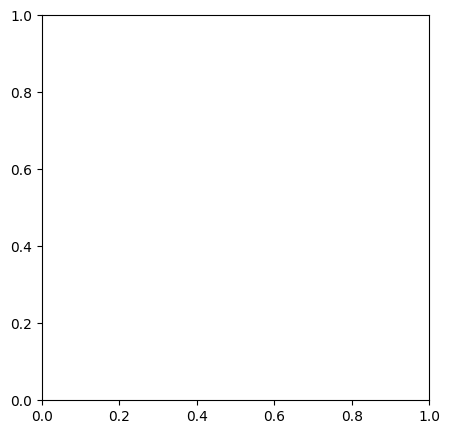

In [32]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5,5))

#axs1.plot(times,  results_N2_abs , label="T /= norm_1 abs")
#axs1.plot(times, np.real(results_N) , label="no norm")
#axs1.plot(times, np.imag(results_N) , label="T /= norm_1.conj()")
axs1.plot(times, results_N2 , label="# T /= norm_1")
axs1.plot(times, results_N3 , label="T /= norm_3")
# axs1.plot(times, results_N4 , label="T /= norm_3.conj()")



axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.grid(True)
axs1.legend()

In [45]:
results_3 = np.array([9.45883844+9.18874270e-16j, 9.45883709+9.76533357e-03j,
       9.45883326+1.95348144e-02j, 9.45882732+2.93077513e-02j,
       9.45881958+3.90834513e-02j, 9.45881037+4.88612190e-02j,
       9.45879997+5.86403549e-02j, 9.45878865+6.84201539e-02j,
       9.45877666+7.81999041e-02j, 9.45876422+8.79788855e-02j,
       9.45875155+9.77563686e-02j, 9.45873881+1.07531613e-01j,
       9.45872617+1.17303866e-01j, 9.45871376+1.27072360e-01j,
       9.4587017 +1.36836316e-01j, 9.45869006+1.46594933e-01j,
       9.45867892+1.56347397e-01j, 9.4586683 +1.66092872e-01j,
       9.45865821+1.75830502e-01j, 9.45864861+1.85559408e-01j,
       9.45863944+1.95278687e-01j, 9.45863062+2.04987412e-01j,
       9.45862201+2.14684627e-01j, 9.45861342+2.24369349e-01j,
       9.45860466+2.34040563e-01j, 9.45859545+2.43697226e-01j,
       9.45858549+2.53338257e-01j, 9.4585744 +2.62962542e-01j,
       9.45856177+2.72568932e-01j, 9.45854711+2.82156236e-01j,
       9.45852986+2.91723228e-01j, 9.4585094 +3.01268634e-01j,
       9.45893719+3.10569408e-01j, 9.45935415+3.19773943e-01j,
       9.45977822+3.28910446e-01j, 9.46021117+3.37979295e-01j,
       9.46065306+3.46978714e-01j, 9.46110325+3.55906161e-01j,
       9.46156072+3.64758703e-01j, 9.46202411+3.73533145e-01j,
       9.46249187+3.82226098e-01j, 9.46296219+3.90834005e-01j,
       9.46343306+3.99353164e-01j, 9.46390223+4.07779735e-01j,
       9.46436724+4.16109745e-01j, 9.46482542+4.24339093e-01j,
       9.46527381+4.32463554e-01j, 9.46582419+4.40604940e-01j,
       9.4666346 +4.49059536e-01j, 9.46752998+4.57494436e-01j,
       9.46844977+4.65880557e-01j, 9.46937157+4.74210217e-01j,
       9.4702821 +4.82479609e-01j, 9.47117141+4.90686247e-01j,
       9.47203101+4.98828275e-01j, 9.47285301+5.06904213e-01j,
       9.47362979+5.14912867e-01j, 9.47435373+5.22853277e-01j,
       9.47501708+5.30724711e-01j, 9.47561188+5.38526660e-01j,
       9.47612988+5.46258847e-01j, 9.47656251+5.53921239e-01j,
       9.47690078+5.61514063e-01j, 9.47804061+5.68727731e-01j,
       9.4794896 +5.76110855e-01j, 9.48095966+5.83495274e-01j,
       9.48239042+5.90845073e-01j, 9.48375754+5.98146684e-01j,
       9.48504463+6.05394221e-01j, 9.48623806+6.12585158e-01j,
       9.48732532+6.19718759e-01j, 9.48829431+6.26795405e-01j,
       9.48913301+6.33816267e-01j, 9.48982926+6.40783136e-01j,
       9.49037065+6.47698331e-01j, 9.49074442+6.54564650e-01j,
       9.49093742+6.61385337e-01j, 9.49093601+6.68164070e-01j,
       9.49167181+6.74103503e-01j, 9.49313215+6.79473996e-01j,
       9.49426704+6.84722657e-01j, 9.49512822+6.89780954e-01j,
       9.49570772+6.94644792e-01j, 9.49599163+6.99310616e-01j,
       9.4959636 +7.03773151e-01j, 9.49560569+7.08025618e-01j,
       9.49489879+7.12059969e-01j, 9.49382279+7.15867030e-01j,
       9.49235669+7.19436552e-01j, 9.49047866+7.22757236e-01j,
       9.48816608+7.25816710e-01j, 9.48539557+7.28601507e-01j,
       9.48214299+7.31097020e-01j, 9.47838345+7.33287457e-01j,
       9.47409136+7.35155787e-01j, 9.46924038+7.36683688e-01j,
       9.46380343+7.37851494e-01j, 9.45775271+7.38638138e-01j,
       9.45105966+7.39021105e-01j, 9.44369497+7.38976380e-01j,
       9.43562851+7.38478402e-01j, 9.42682931+7.37500025e-01j,
       9.41726549+7.36012476e-01j, 9.40690421+7.33985327e-01j,
       9.3957115 +7.31386456e-01j, 9.38365217+7.28182024e-01j,
       9.37068963+7.24336447e-01j, 9.35678561+7.19812358e-01j,
       9.34189992+7.14570575e-01j, 9.32599009+7.08570045e-01j,
       9.30901087+7.01767777e-01j, 9.29091378+6.94118739e-01j,
       9.27164635+6.85575724e-01j, 9.25115139+6.76089157e-01j,
       9.229366  +6.65606838e-01j, 9.20622041+6.54073598e-01j,
       9.18163664+6.41430857e-01j, 9.15552685+6.27616054e-01j,
       9.12779144+6.12561944e-01j, 9.09831677+5.96195737e-01j,
       9.06697251+5.78438063e-01j, 9.03360846+5.59201787e-01j,
       8.99805086+5.38390651e-01j, 8.96009796+5.15897798e-01j,
       8.9195148 +4.91604234e-01j, 8.87602686+4.65377315e-01j,
       8.82931247+4.37069423e-01j, 8.77899356+4.06517055e-01j,
       8.72462424+3.73540666e-01j, 8.66567671+3.37945762e-01j,
       8.60152367+2.99525977e-01j, 8.5314162 +2.58069223e-01j,
       8.45445597+2.13368545e-01j, 8.36956009+1.65240141e-01j,
       8.275417  +1.13552320e-01j, 8.17043144+5.82711359e-02j,
       8.05265713-4.68435431e-04j, 7.91971719-6.22522315e-02j,
       7.768716  -1.26217014e-01j, 7.59615519-1.90790514e-01j,
       7.39788396-2.53298311e-01j, 7.16915055-3.09381970e-01j,
       6.90488884-3.52171659e-01j, 6.60048897-3.71197590e-01j,
       6.25346543-3.51180113e-01j, 5.86657584-2.71241703e-01j,
       5.45276573-1.05880311e-01j, 5.04112991+1.69938523e-01j,
       4.68013428+5.69296915e-01j, 4.43087884+1.07728342e+00j,
       4.3454381 +1.64118122e+00j, 4.43929238+2.18168748e+00j,
       4.68047979+2.62460950e+00j, 5.00685086+2.92964605e+00j,
       5.35551866+3.09560590e+00j, 5.682105  +3.14613815e+00j,
       5.96393525+3.11245713e+00j, 6.19435437+3.02270247e+00j,
       6.37571324+2.89822197e+00j, 6.51426366+2.75371091e+00j,
       6.6172508 +2.59869075e+00j, 6.69153492+2.43908048e+00j,
       6.74307298+2.27844500e+00j, 6.77681901+2.11887458e+00j,
       6.79680092+1.96156692e+00j, 6.80625425+1.80719848e+00j,
       6.80776039+1.65615515e+00j, 6.80336927+1.50867183e+00j,
       6.79470193+1.36491435e+00j, 6.78303404+1.22502495e+00j,
       6.76936383+1.08914549e+00j, 6.75446784+9.57427123e-01j,
       6.73894734+8.30032512e-01j, 6.72326777+7.07134245e-01j,
       6.70779235+5.88912136e-01j, 6.69281072+4.75550857e-01j,
       6.67856285+3.67238741e-01j, 6.66525801+2.64167903e-01j,
       6.65308855+1.66535332e-01j, 6.64223847+7.45442024e-02j,
       6.6328869 -1.15955574e-02j, 6.62520707-9.16683611e-02j,
       6.61936207-1.65456385e-01j, 6.61549879-2.32745491e-01j,
       6.61374172-2.93333282e-01j, 6.61418814-3.47038429e-01j,
       6.61690585-3.93710124e-01j, 6.62193364-4.33236510e-01j,
       6.6292847 -4.65551150e-01j, 6.63895214-4.90637030e-01j,
       6.65091581-5.08528001e-01j, 6.66514953-5.19307944e-01j,
       6.68162786-5.23108212e-01j, 6.70033186-5.20103957e-01j,
       6.72125338-5.10509961e-01j, 6.74439773-4.94576469e-01j,
       6.76978482-4.72585376e-01j, 6.79744871-4.44846963e-01j,
       6.82743585-4.11697241e-01j, 6.85980217-3.73495870e-01j,
       6.89460923-3.30624499e-01j])

In [46]:
esults_no_norm = np.array([ 9.73777595-6.37453433e-16j,  9.73784404+1.51875355e-02j,
        9.73804839+3.03834182e-02j,  9.73838914+4.55866396e-02j,
        9.73886646+6.07961978e-02j,  9.73948049+7.60110971e-02j,
        9.74023141+9.12303468e-02j,  9.74111939+1.06452961e-01j,
        9.74214459+1.21677955e-01j,  9.7433072 +1.36904350e-01j,
        9.74460742+1.52131164e-01j,  9.74604543+1.67357419e-01j,
        9.74762143+1.82582133e-01j,  9.74933563+1.97804323e-01j,
        9.75118823+2.13023003e-01j,  9.75317943+2.28237182e-01j,
        9.75530945+2.43445860e-01j,  9.7575785 +2.58648035e-01j,
        9.75998678+2.73842689e-01j,  9.76253451+2.89028799e-01j,
        9.76522188+3.04205326e-01j,  9.76804909+3.19371217e-01j,
        9.77101634+3.34525404e-01j,  9.7741238 +3.49666799e-01j,
        9.77737166+3.64794295e-01j,  9.78076005+3.79906761e-01j,
        9.78428914+3.95003041e-01j,  9.78795904+4.10081951e-01j,
        9.79176986+4.25142278e-01j,  9.79572168+4.40182773e-01j,
        9.79981456+4.55202152e-01j,  9.80404853+4.70199090e-01j,
        9.80885258+4.85628151e-01j,  9.81383926+5.01015052e-01j,
        9.81899331+5.16413745e-01j,  9.82431118+5.31828356e-01j,
        9.8297909 +5.47260758e-01j,  9.83543097+5.62712304e-01j,
        9.84122998+5.78184176e-01j,  9.84718654+5.93677483e-01j,
        9.85329917+6.09193301e-01j,  9.85956628+6.24732686e-01j,
        9.86598615+6.40296677e-01j,  9.87255688+6.55886295e-01j,
        9.87927639+6.71502543e-01j,  9.88614238+6.87146398e-01j,
        9.89315233+7.02818808e-01j,  9.89994457+7.18271092e-01j,
        9.90625821+7.32933825e-01j,  9.91261706+7.47479123e-01j,
        9.9190797 +7.61965801e-01j,  9.92566509+7.76407979e-01j,
        9.93238215+7.90811343e-01j,  9.93923534+8.05178379e-01j,
        9.94622698+8.19509898e-01j,  9.95335821+8.33805656e-01j,
        9.96062948+8.48064658e-01j,  9.96804083+8.62285318e-01j,
        9.97559199+8.76465542e-01j,  9.98328248+8.90602769e-01j,
        9.99111169+9.04693991e-01j,  9.99907884+9.18735748e-01j,
       10.00718306+9.32724117e-01j, 10.01548527+9.45788526e-01j,
       10.02415874+9.58821720e-01j, 10.03302255+9.71747297e-01j,
       10.04206026+9.84537870e-01j, 10.05126718+9.97175809e-01j,
       10.06064233+1.00964622e+00j, 10.07018618+1.02193514e+00j,
       10.07989977+1.03402882e+00j, 10.08978425+1.04591349e+00j,
       10.09984058+1.05757527e+00j, 10.11006933+1.06900014e+00j,
       10.12047055+1.08017395e+00j, 10.1310436 +1.09108253e+00j,
       10.1417871 +1.10171175e+00j, 10.15269884+1.11204756e+00j,
       10.16353196+1.12145750e+00j, 10.17428438+1.13265885e+00j,
       10.18495277+1.14361188e+00j, 10.19583217+1.15412083e+00j,
       10.20695477+1.16421059e+00j, 10.21833633+1.17388264e+00j,
       10.22999352+1.18312777e+00j, 10.24194593+1.19193061e+00j,
       10.25421641+1.20027106e+00j, 10.26683127+1.20812468e+00j,
       10.27982061+1.21546276e+00j, 10.29321866+1.22225223e+00j,
       10.30706438+1.22845550e+00j, 10.3214021 +1.23403026e+00j,
       10.3362822 +1.23892914e+00j, 10.35176198+1.24309936e+00j,
       10.36601523+1.24714090e+00j, 10.38031983+1.25121632e+00j,
       10.39509892+1.25477832e+00j, 10.4103865 +1.25771946e+00j,
       10.4262377 +1.25996756e+00j, 10.44272021+1.26145961e+00j,
       10.45991385+1.26213457e+00j, 10.47791164+1.26193042e+00j,
       10.49682141+1.26078266e+00j, 10.51676777+1.25862324e+00j,
       10.53789451+1.25537963e+00j, 10.56036721+1.25097382e+00j,
       10.58437637+1.24532120e+00j, 10.61014096+1.23832907e+00j,
       10.63791243+1.22989477e+00j, 10.66797939+1.21990319e+00j,
       10.70067293+1.20822353e+00j, 10.73637271+1.19470482e+00j,
       10.77551398+1.17917011e+00j, 10.81859555+1.16140849e+00j,
       10.86618897+1.14116449e+00j, 10.9189488 +1.11812377e+00j,
       10.97762419+1.09189381e+00j, 11.04307141+1.06197788e+00j,
       11.11626709+1.02773989e+00j, 11.19832113+9.88356799e-01j,
       11.29048736+9.42754196e-01j, 11.39416849+8.89519123e-01j,
       11.51090902+8.26782271e-01j, 11.64236501+7.52059649e-01j,
       11.7902315 +6.62041925e-01j, 11.95609526+5.52319514e-01j,
       12.14115918+4.17036359e-01j, 12.34575274+2.48482565e-01j,
       12.56849907+3.66804621e-02j, 12.80496357-2.30882767e-01j,
       13.04559967-5.69029327e-01j, 13.27294353-9.93501990e-01j,
       13.45851589-1.51734642e+00j, 13.56106903-2.14390547e+00j,
       13.52961321-2.85646683e+00j, 13.31550622-3.60836269e+00j,
       12.8940126 -4.32262649e+00j, 12.2852423 -4.91026236e+00j,
       11.55648463-5.30301997e+00j, 10.79848987-5.47938904e+00j,
       10.09152867-5.46515547e+00j,  9.48430791-5.31265148e+00j,
        8.99296633-5.07723368e+00j,  8.61158428-4.80341744e+00j,
        8.32381284-4.52128368e+00j,  8.11082953-4.24852430e+00j,
        7.95537232-3.99408613e+00j,  7.84318167-3.76143908e+00j,
        7.76311781-3.55092545e+00j,  7.70674659-3.36126537e+00j,
        7.6677945 -3.19045283e+00j,  7.64164111-3.03625830e+00j,
        7.62490207-2.89649337e+00j,  7.61510649-2.76913783e+00j,
        7.61045484-2.65239005e+00j,  7.60964037-2.54467667e+00j,
        7.6117182 -2.44464177e+00j,  7.61600963-2.35112697e+00j,
        7.62203213-2.26314852e+00j,  7.62944788-2.17987453e+00j,
        7.63802588-2.10060383e+00j,  7.64761384-2.02474701e+00j,
        7.65811723-1.95180983e+00j,  7.66948363-1.88137887e+00j,
        7.68169094-1.81310909e+00j,  7.69473845-1.74671331e+00j,
        7.70864014-1.68195305e+00j,  7.72341956-1.61863077e+00j,
        7.73910596-1.55658313e+00j,  7.75573137-1.49567522e+00j,
        7.77332838-1.43579556e+00j,  7.79192852-1.37685174e+00j,
        7.81156103-1.31876656e+00j,  7.83225194-1.26147479e+00j,
        7.85402351-1.20492010e+00j,  7.87689372-1.14905252e+00j,
        7.90087601-1.09382608e+00j,  7.92597913-1.03919672e+00j,
        7.95220696-9.85120379e-01j,  7.97955855-9.31551348e-01j,
        8.00802803-8.78440694e-01j,  8.03760464-8.25734887e-01j,
        8.06827269-7.73374542e-01j,  8.10001155-7.21293287e-01j,
        8.13279551-6.69416750e-01j,  8.16659371-6.17661666e-01j,
        8.20136983-5.65935087e-01j,  8.23708185-5.14133718e-01j,
        8.27368155-4.62143365e-01j,  8.31111398-4.09838504e-01j,
        8.34931668-3.57081987e-01j,  8.38821875-3.03724879e-01j,
        8.42773975-2.49606458e-01j,  8.4677883 -1.94554377e-01j,
        8.50826047-1.38385023e-01j,  8.54903788-8.09040919e-02j,
        8.58998557-2.19074291e-02j,  8.63094952+3.88178357e-02j,
        8.67175393+1.01491787e-01j,  8.71219822+1.66339790e-01j,
        8.75205388+2.33590041e-01j])

In [47]:
results_1_conj = np.array([ 9.45883844+2.72985905e-16j,  9.45883709+9.76533357e-03j,
        9.45883326+1.95348144e-02j,  9.45882732+2.93077513e-02j,
        9.45881958+3.90834513e-02j,  9.45881037+4.88612190e-02j,
        9.45879997+5.86403549e-02j,  9.45878865+6.84201539e-02j,
        9.45877666+7.81999041e-02j,  9.45876422+8.79788855e-02j,
        9.45875155+9.77563686e-02j,  9.45873881+1.07531613e-01j,
        9.45872617+1.17303866e-01j,  9.45871376+1.27072360e-01j,
        9.4587017 +1.36836316e-01j,  9.45869006+1.46594933e-01j,
        9.45867892+1.56347397e-01j,  9.4586683 +1.66092872e-01j,
        9.45865821+1.75830502e-01j,  9.45864861+1.85559408e-01j,
        9.45863944+1.95278687e-01j,  9.45863062+2.04987412e-01j,
        9.45862201+2.14684627e-01j,  9.45861342+2.24369349e-01j,
        9.45860466+2.34040563e-01j,  9.45859545+2.43697226e-01j,
        9.45858549+2.53338257e-01j,  9.4585744 +2.62962542e-01j,
        9.45856177+2.72568932e-01j,  9.45854711+2.82156236e-01j,
        9.45852986+2.91723228e-01j,  9.4585094 +3.01268634e-01j,
        9.45861571+3.10759915e-01j,  9.45879419+3.20255303e-01j,
        9.45901521+3.29737366e-01j,  9.45926806+3.39204621e-01j,
        9.45954755+3.48656069e-01j,  9.45985057+3.58090750e-01j,
        9.46017496+3.67507666e-01j,  9.46051902+3.76905783e-01j,
        9.46088133+3.86284021e-01j,  9.46126059+3.95641265e-01j,
        9.46165553+4.04976359e-01j,  9.4620649 +4.14288114e-01j,
        9.46248739+4.23575306e-01j,  9.46292163+4.32836676e-01j,
        9.46336615+4.42070928e-01j,  9.4641994 +4.50961457e-01j,
        9.46567955+4.59485144e-01j,  9.46725361+4.67904598e-01j,
        9.46886633+4.76235213e-01j,  9.47050203+4.84479435e-01j,
        9.47215203+4.92636339e-01j,  9.47380944+5.00704008e-01j,
        9.47546789+5.08680146e-01j,  9.47712106+5.16562284e-01j,
        9.4787625 +5.24347859e-01j,  9.48038554+5.32034255e-01j,
        9.48198329+5.39618835e-01j,  9.48354864+5.47098959e-01j,
        9.48507424+5.54472010e-01j,  9.48655252+5.61735415e-01j,
        9.4879757 +5.68886672e-01j,  9.49013697+5.76469835e-01j,
        9.49242502+5.84034389e-01j,  9.49458241+5.91490961e-01j,
        9.49662898+5.98850063e-01j,  9.4985662 +6.06113546e-01j,
        9.50038883+6.13282575e-01j,  9.50208855+6.20358265e-01j,
        9.50365522+6.27341803e-01j,  9.50507739+6.34234523e-01j,
        9.50634257+6.41037956e-01j,  9.50743732+6.47753882e-01j,
        9.50834729+6.54384369e-01j,  9.50905725+6.60931814e-01j,
        9.50955107+6.67398986e-01j,  9.50981173+6.73789056e-01j,
        9.5100342 +6.79960858e-01j,  9.51012372+6.86285669e-01j,
        9.50994446+6.92713385e-01j,  9.50948759+6.99172936e-01j,
        9.50872586+7.05613624e-01j,  9.5076297 +7.12013798e-01j,
        9.50617002+7.18364632e-01j,  9.50431768+7.24662633e-01j,
        9.50204285+7.30906751e-01j,  9.49931474+7.37097178e-01j,
        9.49610131+7.43234783e-01j,  9.49236916+7.49320823e-01j,
        9.48808336+7.55356764e-01j,  9.48320736+7.61344168e-01j,
        9.47770283+7.67284604e-01j,  9.47152954+7.73179574e-01j,
        9.46461826+7.78814464e-01j,  9.45711054+7.84226969e-01j,
        9.44888776+7.89532702e-01j,  9.4398953 +7.94738696e-01j,
        9.43008398+7.99846236e-01j,  9.41940534+8.04854712e-01j,
        9.40781014+8.09762375e-01j,  9.39524765+8.14566560e-01j,
        9.38166526+8.19263724e-01j,  9.36700814+8.23849425e-01j,
        9.35121897+8.28318256e-01j,  9.33423761+8.32663756e-01j,
        9.3160008 +8.36878297e-01j,  9.29644179+8.40952946e-01j,
        9.27548991+8.44877304e-01j,  9.25331291+8.49147652e-01j,
        9.23106589+8.53795491e-01j,  9.20764766+8.58248396e-01j,
        9.18289122+8.62630662e-01j,  9.15669872+8.66989256e-01j,
        9.12898162+8.71352976e-01j,  9.09964942+8.75745028e-01j,
        9.06860537+8.80187042e-01j,  9.03574381+8.84700792e-01j,
        9.00094772+8.89309131e-01j,  8.96408621+8.94036602e-01j,
        8.92501155+8.98909883e-01j,  8.88355557+9.03958136e-01j,
        8.83952531+9.09213273e-01j,  8.7926975 +9.14710091e-01j,
        8.74281168+9.20486240e-01j,  8.68826065+9.20672854e-01j,
        8.6291481 +9.18473647e-01j,  8.56620183+9.14606358e-01j,
        8.49903612+9.09346343e-01j,  8.42721265+9.02733086e-01j,
        8.35020877+8.94700350e-01j,  8.2673864 +8.85105602e-01j,
        8.17795565+8.73727409e-01j,  8.08092683+8.60244029e-01j,
        7.97504499+8.44192454e-01j,  7.85869913+8.24899696e-01j,
        7.72979456+8.01369295e-01j,  7.58557249+7.72091326e-01j,
        7.42235442+7.34716253e-01j,  7.23518497+6.85477558e-01j,
        7.02902029+6.04167790e-01j,  6.7904159 +4.61330414e-01j,
        6.50755085+2.67417849e-01j,  6.16582933-1.41251980e-02j,
        5.75250281-4.53361479e-01j,  5.28084806-1.19388546e+00j,
        4.91083497-2.52586946e+00j,  5.43111287-4.78076011e+00j,
        8.5088447 -6.57434210e+00j, 11.79964617-4.71763266e+00j,
       12.19125846-2.12951450e+00j, 11.53715842-7.21890811e-01j,
       10.85421182-4.55309034e-02j, 10.30250465+2.91118136e-01j,
        9.86829913+4.65030575e-01j,  9.52050586+5.54532975e-01j,
        9.34076622+6.06265833e-01j,  9.22078135+6.43643609e-01j,
        9.13332234+6.77324313e-01j,  9.06132482+7.09362772e-01j,
        8.99692055+7.37104547e-01j,  8.93783276+7.59768936e-01j,
        8.88325345+7.77458114e-01j,  8.83281399+7.90534194e-01j,
        8.78632598+7.99407954e-01j,  8.74370181+8.04472519e-01j,
        8.70492317+8.06085793e-01j,  8.67002498+8.04569423e-01j,
        8.63908518+8.00213063e-01j,  8.61221738+7.93279826e-01j,
        8.58956515+7.84011402e-01j,  8.57129731+7.72632355e-01j,
        8.55760397+7.59353443e-01j,  8.54869315+7.44373969e-01j,
        8.54478774+7.27883224e-01j,  8.54612291+7.10061074e-01j,
        8.55294373+6.91077737e-01j,  8.56550293+6.71092807e-01j,
        8.58405905+6.50253538e-01j,  8.60887456+6.28692427e-01j,
        8.64021424+6.06524110e-01j,  8.67834361+5.83841576e-01j,
        8.72352744+5.60711740e-01j,  8.77602822+5.37170357e-01j,
        8.8361046 +5.13216340e-01j,  8.90400962+4.88805474e-01j,
        8.97998852+4.63843588e-01j,  9.06427611+4.38179238e-01j,
        9.15709333+4.11595980e-01j,  9.25864278+3.83804340e-01j,
        9.36910282+3.54433660e-01j,  9.48862009+3.23024033e-01j,
        9.61729968+2.89018664e-01j,  9.75519298+2.51757076e-01j,
        9.90228239+2.10469767e-01j, 10.05846281+1.64275080e-01j,
       10.22351966+1.12179262e-01j, 10.39710322+5.30809439e-02j,
       10.57869981-1.42185528e-02j, 10.76760042-9.09974296e-02j,
       10.96286816-1.78586459e-01j])

In [48]:
results_1 = np.array([ 9.45883844+3.23271857e-16j,  9.45883709+9.76533357e-03j,
        9.45883326+1.95348144e-02j,  9.45882732+2.93077513e-02j,
        9.45881958+3.90834513e-02j,  9.45881037+4.88612190e-02j,
        9.45879997+5.86403549e-02j,  9.45878865+6.84201539e-02j,
        9.45877666+7.81999041e-02j,  9.45876422+8.79788855e-02j,
        9.45875155+9.77563686e-02j,  9.45873881+1.07531613e-01j,
        9.45872617+1.17303866e-01j,  9.45871376+1.27072360e-01j,
        9.4587017 +1.36836316e-01j,  9.45869006+1.46594933e-01j,
        9.45867993+1.56331921e-01j,  9.4586706 +1.66045155e-01j,
        9.45866077+1.75748803e-01j,  9.45865038+1.85441971e-01j,
        9.45863931+1.95123746e-01j,  9.45862743+2.04793201e-01j,
        9.45861458+2.14449388e-01j,  9.45860053+2.24091338e-01j,
        9.45858506+2.33718061e-01j,  9.45856787+2.43328546e-01j,
        9.45854864+2.52921756e-01j,  9.45852699+2.62496626e-01j,
        9.4585025 +2.72052066e-01j,  9.45847468+2.81586957e-01j,
        9.458443  +2.91100148e-01j,  9.45840685+3.00590459e-01j,
        9.45857725+3.10415123e-01j,  9.45876735+3.20245320e-01j,
        9.45896002+3.30064799e-01j,  9.45915494+3.39870868e-01j,
        9.45935148+3.49661720e-01j,  9.4595487 +3.59435797e-01j,
        9.45974545+3.69191633e-01j,  9.45994042+3.78927795e-01j,
        9.46013207+3.88642856e-01j,  9.46031872+3.98335381e-01j,
        9.46049849+4.08003922e-01j,  9.46066932+4.17647011e-01j,
        9.46082893+4.27263159e-01j,  9.46097485+4.36850854e-01j,
        9.46110438+4.46408558e-01j,  9.46171389+4.55540691e-01j,
        9.46295079+4.64021823e-01j,  9.46421905+4.72406225e-01j,
        9.4654924 +4.80703807e-01j,  9.46676289+4.88914660e-01j,
        9.46802513+4.97037250e-01j,  9.46927426+5.05069519e-01j,
        9.47050545+5.13009180e-01j,  9.47171371+5.20853841e-01j,
        9.47289386+5.28601054e-01j,  9.47404042+5.36248354e-01j,
        9.47514762+5.43793278e-01j,  9.47620937+5.51233385e-01j,
        9.47721921+5.58566273e-01j,  9.47817034+5.65789590e-01j,
        9.47905556+5.72901054e-01j,  9.48147394+5.80663364e-01j,
        9.48408607+5.88445271e-01j,  9.48667023+5.96118575e-01j,
        9.48923133+6.03689929e-01j,  9.49176604+6.11158850e-01j,
        9.49426872+6.18523196e-01j,  9.4967324 +6.25780773e-01j,
        9.49914896+6.32929884e-01j,  9.50150917+6.39969441e-01j,
        9.50380275+6.46898847e-01j,  9.50601841+6.53717756e-01j,
        9.50814393+6.60425807e-01j,  9.51016626+6.67022413e-01j,
        9.51207151+6.73506628e-01j,  9.51384504+6.79877085e-01j,
        9.51546338+6.85945964e-01j,  9.51713319+6.91329011e-01j,
        9.51859572+6.96468788e-01j,  9.51981415+7.01407100e-01j,
        9.52077221+7.06146662e-01j,  9.52145279+7.10684907e-01j,
        9.52183754+7.15017671e-01j,  9.52190704+7.19139988e-01j,
        9.52164092+7.23046317e-01j,  9.52101788+7.26730646e-01j,
        9.52001571+7.30186536e-01j,  9.51861123+7.33407166e-01j,
        9.51678034+7.36385359e-01j,  9.51449793+7.39113619e-01j,
        9.5117379 +7.41584167e-01j,  9.50847308+7.43788982e-01j,
        9.50507792+7.46189386e-01j,  9.50117427+7.48455112e-01j,
        9.49676096+7.50417258e-01j,  9.49182626+7.52060456e-01j,
        9.48635411+7.53373254e-01j,  9.48032686+7.54344423e-01j,
        9.47372591+7.54962445e-01j,  9.46653189+7.55215454e-01j,
        9.45872473+7.55091281e-01j,  9.45028356+7.54577508e-01j,
        9.44118668+7.53661531e-01j,  9.43141139+7.52330605e-01j,
        9.4209338 +7.50571873e-01j,  9.4097286 +7.48372368e-01j,
        9.39776876+7.45718994e-01j,  9.3857732 +7.42671170e-01j,
        9.3740189 +7.39125943e-01j,  9.36154511+7.34871432e-01j,
        9.34834009+7.29926166e-01j,  9.33438471+7.24257031e-01j,
        9.31965119+7.17816384e-01j,  9.304105  +7.10547156e-01j,
        9.28770517+7.02383218e-01j,  9.27040392+6.93248375e-01j,
        9.25214577+6.83054657e-01j,  9.23286648+6.71700007e-01j,
        9.21249149+6.59065326e-01j,  9.19093414+6.45010715e-01j,
        9.1680934 +6.29370707e-01j,  9.14385103+6.11948172e-01j,
        9.118068  +5.92506459e-01j,  9.0922392 +5.69866336e-01j,
        9.06378954+5.42612048e-01j,  9.03335166+5.12746055e-01j,
        9.00060156+4.79968751e-01j,  8.96515895+4.43812480e-01j,
        8.92656331+4.03739692e-01j,  8.88423473+3.59116582e-01j,
        8.83742352+3.09177601e-01j,  8.78513924+2.52982832e-01j,
        8.72604569+1.89364432e-01j,  8.6583001 +1.16858159e-01j,
        8.57929914+3.36170711e-02j,  8.48526513-6.26907112e-02j,
        8.37054928-1.74981886e-01j,  8.226416  -3.06785878e-01j,
        8.02532091-4.67370583e-01j,  7.72976039-6.68157410e-01j,
        7.31247368-9.02515210e-01j,  6.6806777 -1.16154062e+00j,
        5.65375428-1.37932296e+00j,  3.89132047-1.23751273e+00j,
        1.2127899 +5.64364146e-01j,  0.76619537+5.88814626e+00j,
        5.56875826+8.58022471e+00j,  8.72148616+7.18880586e+00j,
        9.8285533 +5.65095287e+00j, 10.19740011+4.59127102e+00j,
       10.31878969+3.87362535e+00j, 10.35256375+3.36680515e+00j,
       10.35498098+2.99182188e+00j, 10.34761147+2.70254840e+00j,
       10.33923237+2.47116644e+00j, 10.33350211+2.28016271e+00j,
       10.33190341+2.11803679e+00j, 10.33495725+1.97693798e+00j,
       10.34275213+1.85131428e+00j, 10.35518369+1.73710999e+00j,
       10.372065  +1.63127195e+00j, 10.39317682+1.53143584e+00j,
       10.41828908+1.43572127e+00j, 10.44716821+1.34259476e+00j,
       10.47957763+1.25077622e+00j, 10.51527486+1.15917430e+00j,
       10.5540071 +1.06684122e+00j, 10.59550639+9.72941298e-01j,
       10.63948466+8.76729146e-01j, 10.68562918+7.77535125e-01j,
       10.73359856+6.74756136e-01j, 10.78301946+5.67850605e-01j,
       10.83348423+4.56336729e-01j, 10.88454956+3.39793326e-01j,
       10.93573637+2.17862740e-01j, 10.98653114+9.02553496e-02j,
       11.0363887 -4.32447408e-02j, 11.0847368 -1.82773266e-01j,
       11.13098258-3.28379057e-01j, 11.17452091-4.80017486e-01j,
       11.2147448 -6.37544663e-01j, 11.25105778-8.00712982e-01j,
       11.28288797-9.69168663e-01j, 11.30970362-1.14245197e+00j,
       11.33102951-1.32000073e+00j, 11.34646343-1.50115757e+00j,
       11.35569191-1.68518136e+00j, 11.35850409-1.87126268e+00j,
       11.35480269-2.05854314e+00j, 11.34461099-2.24613781e+00j,
       11.32807513-2.43315974e+00j, 11.30546123-2.61874519e+00j,
       11.27714715-2.80207823e+00j, 11.24360943-2.98241306e+00j,
       11.20540603-3.15909287e+00j, 11.16315608-3.33156415e+00j,
       11.11751792-3.49938577e+00j, 11.06916665-3.66223277e+00j,
       11.0187727 -3.81989492e+00j])

In [49]:
results_3_conj = np.array([ 9.45883844+7.17730464e-16j,  9.45883709+9.76533357e-03j,
        9.45883326+1.95348144e-02j,  9.45882732+2.93077513e-02j,
        9.45881958+3.90834513e-02j,  9.45881037+4.88612190e-02j,
        9.45879997+5.86403549e-02j,  9.45878865+6.84201539e-02j,
        9.45877666+7.81999041e-02j,  9.45876422+8.79788855e-02j,
        9.45875155+9.77563686e-02j,  9.45873881+1.07531613e-01j,
        9.45872617+1.17303866e-01j,  9.45871376+1.27072360e-01j,
        9.4587017 +1.36836316e-01j,  9.45869006+1.46594933e-01j,
        9.45867892+1.56347397e-01j,  9.4586683 +1.66092872e-01j,
        9.45865821+1.75830502e-01j,  9.45864861+1.85559408e-01j,
        9.45863944+1.95278687e-01j,  9.45863062+2.04987412e-01j,
        9.45862201+2.14684627e-01j,  9.45861342+2.24369349e-01j,
        9.45860466+2.34040563e-01j,  9.45859545+2.43697226e-01j,
        9.45858549+2.53338257e-01j,  9.4585744 +2.62962542e-01j,
        9.45856177+2.72568932e-01j,  9.45854711+2.82156236e-01j,
        9.45852986+2.91723228e-01j,  9.4585094 +3.01268634e-01j,
        9.45871453+3.10815844e-01j,  9.45894105+3.20315763e-01j,
        9.45917906+3.29780559e-01j,  9.45942517+3.39212385e-01j,
        9.45967728+3.48611334e-01j,  9.45993369+3.57976789e-01j,
        9.46019278+3.67307795e-01j,  9.46045292+3.76603208e-01j,
        9.46071242+3.85861763e-01j,  9.4609695 +3.95082105e-01j,
        9.46122223+4.04262814e-01j,  9.46146853+4.13402418e-01j,
        9.46170617+4.22499398e-01j,  9.46193269+4.31552198e-01j,
        9.46214547+4.40559232e-01j,  9.46260392+4.49102401e-01j,
        9.46340547+4.56783639e-01j,  9.46427984+4.64322846e-01j,
        9.46515163+4.71742663e-01j,  9.46600574+4.79044008e-01j,
        9.46683435+4.86225553e-01j,  9.46763131+4.93285312e-01j,
        9.4683909 +5.00221041e-01j,  9.46910747+5.07030389e-01j,
        9.46977523+5.13710974e-01j,  9.47038819+5.20260426e-01j,
        9.47094009+5.26676416e-01j,  9.4714244 +5.32956685e-01j,
        9.47183425+5.39099057e-01j,  9.47216244+5.45101467e-01j,
        9.47240139+5.50961976e-01j,  9.47481604+5.57962879e-01j,
        9.47725854+5.64928656e-01j,  9.47960501+5.71700721e-01j,
        9.48187762+5.78339476e-01j,  9.48407513+5.84855625e-01j,
        9.48619244+5.91251868e-01j,  9.48822269+5.97529035e-01j,
        9.49015772+6.03687433e-01j,  9.4919883 +6.09727256e-01j,
        9.4937042 +6.15648749e-01j,  9.49529423+6.21452288e-01j,
        9.49674624+6.27138425e-01j,  9.49804708+6.32707923e-01j,
        9.49918263+6.38161781e-01j,  9.50013769+6.43501251e-01j,
        9.50105871+6.48087782e-01j,  9.50255052+6.51585884e-01j,
        9.50397938+6.54808321e-01j,  9.50530127+6.57737115e-01j,
        9.50649212+6.60358419e-01j,  9.5075362 +6.62660265e-01j,
        9.50842178+6.64631139e-01j,  9.50913939+6.66259436e-01j,
        9.50968105+6.67533235e-01j,  9.51003993+6.68440193e-01j,
        9.51021014+6.68967493e-01j,  9.51018661+6.69101796e-01j,
        9.50996504+6.68829215e-01j,  9.50954188+6.68135275e-01j,
        9.5089143 +6.67004882e-01j,  9.50808021+6.65422280e-01j,
        9.50703823+6.63370998e-01j,  9.5057877 +6.60833804e-01j,
        9.5043287 +6.57792626e-01j,  9.50266199+6.54228488e-01j,
        9.50078905+6.50121405e-01j,  9.49871206+6.45450289e-01j,
        9.49643383+6.40192813e-01j,  9.49395783+6.34325268e-01j,
        9.49128811+6.27822392e-01j,  9.48842929+6.20657166e-01j,
        9.48538645+6.12800581e-01j,  9.48216514+6.04221358e-01j,
        9.47877123+5.94885636e-01j,  9.47521088+5.84756591e-01j,
        9.47149041+5.73794005e-01j,  9.46761622+5.61953758e-01j,
        9.46359463+5.49187235e-01j,  9.4594318 +5.35440636e-01j,
        9.45513355+5.20654169e-01j,  9.45070521+5.04761107e-01j,
        9.44615143+4.87686682e-01j,  9.44147604+4.69346778e-01j,
        9.43668173+4.49646404e-01j,  9.43176992+4.28477873e-01j,
        9.42674038+4.05718648e-01j,  9.42159093+3.81228768e-01j,
        9.41631704+3.54847758e-01j,  9.41091132+3.26390906e-01j,
        9.40536285+2.95644742e-01j,  9.39965642+2.62361511e-01j,
        9.39377141+2.26252382e-01j,  9.38768036+1.86979020e-01j,
        9.38134701+1.44143063e-01j,  9.37472361+9.72728582e-02j,
        9.36774719+4.58066142e-02j,  9.36033426-1.09292166e-02j,
        9.35237332-7.37479374e-02j,  9.34371397-1.43639258e-01j,
        9.33415101-2.21817810e-01j,  9.32340086-3.09788165e-01j,
        9.31106574-4.09433088e-01j,  9.29657871-5.23135088e-01j,
        9.27911694-6.53946349e-01j,  9.2574622 -8.05830221e-01j,
        9.22976993-9.84010199e-01j,  9.1931756 -1.19548280e+00j,
        9.14310087-1.44978291e+00j,  9.0719826 -1.76013789e+00j,
        8.96684257-2.14520443e+00j,  8.80441156-2.63159017e+00j,
        8.54083113-3.25701142e+00j,  8.08881506-4.07178509e+00j,
        7.26569893-5.12578161e+00j,  5.68439154-6.37983888e+00j,
        2.65190988-7.30376927e+00j, -1.97304823-5.89768514e+00j,
       -4.63058267-5.14928908e-01j, -2.59210654+4.32716194e+00j,
        0.50321861+6.03096233e+00j,  2.71001513+6.16913808e+00j,
        4.09477338+5.85262837e+00j,  4.96564433+5.45848744e+00j,
        5.52768748+5.09181392e+00j,  5.8982016 +4.77502157e+00j,
        6.14421938+4.50683619e+00j,  6.30532332+4.28011415e+00j,
        6.40581739+4.08714666e+00j,  6.46119844+3.92109046e+00j,
        6.48169799+3.77619708e+00j,  6.47429507+3.64769433e+00j,
        6.44390611+3.53159526e+00j,  6.39411619+3.42451972e+00j,
        6.32764594+3.32355020e+00j,  6.24666086+3.22612354e+00j,
        6.15298337+3.12995414e+00j,  6.04824273+3.03298392e+00j,
        5.93398281+2.93335441e+00j,  5.81173974+2.82939708e+00j,
        5.6830958 +2.71963866e+00j,  5.54971338+2.60281785e+00j,
        5.41335062+2.47791001e+00j,  5.27585993+2.34415579e+00j,
        5.13917061+2.20108978e+00j,  5.00525699+2.04856455e+00j,
        4.87609474+1.88676633e+00j,  4.75360859+1.71621882e+00j,
        4.63961577+1.53777281e+00j,  4.53576978+1.35258081e+00j,
        4.44350912+1.16205732e+00j,  4.36401499+9.67827131e-01j,
        4.29818097+7.71664845e-01j,  4.24659624+5.75429871e-01j,
        4.2095426 +3.81001047e-01j,  4.18700425+1.90214717e-01j,
        4.17868842+4.80927617e-03j,  4.18405431-1.73621706e-01j,
        4.20234814-3.43666669e-01j,  4.23264175-5.04123174e-01j,
        4.27387293-6.54015140e-01j,  4.32488589-7.92600733e-01j,
        4.38447058-9.19371644e-01j,  4.45139951-1.03404463e+00j,
        4.52446133-1.13654633e+00j,  4.60248999-1.22699256e+00j,
        4.68438882-1.30566349e+00j,  4.76914898-1.37297616e+00j,
        4.85586216-1.42945600e+00j])

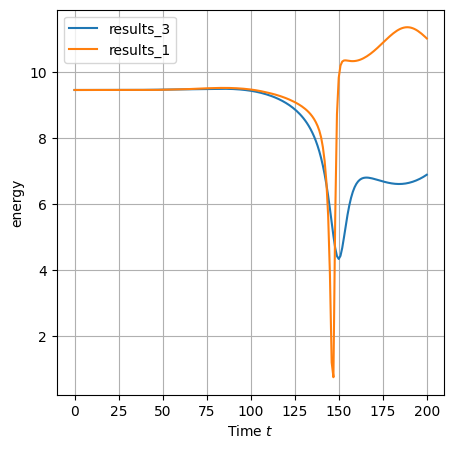

In [50]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5,5))

#axs1.plot( np.real(results_N) , label="case 1 real")

#axs1.plot( results_1_conj , label="results_1_conj")
axs1.plot( results_3 , label="results_3")
#axs1.plot( results_3_conj , label="results_3_conj")
axs1.plot( results_1 , label="results_1")
#axs1.plot( np.real(esults_no_norm), label="esults_no_norm")

#axs1.plot( results_1_conj, label="results_1_conj")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.grid(True)
axs1.legend()

# TEST NORMALIZATION

In [93]:
ttn = tdvp_ex1.state
print(ttn.operator_expectation_value_Lindblad(I))
print(np.abs(ttn.operator_expectation_value_Lindblad(I)))
A = ttn.operator_expectation_value_Lindblad(N) / ttn.operator_expectation_value_Lindblad(I)
# ttn = ptn.normalize_ttn_Lindblad_3(ttn, orth_center_id_1 , orth_center_id_2) 
ttn = ptn.normalize_ttn_Lindblad_4(ttn, tdvp_ex1.update_path[0]) 
#ttn = ptn.normalize_ttn_Lindblad_1(ttn)
print(ttn.operator_expectation_value_Lindblad(I))
print(np.abs(ttn.operator_expectation_value_Lindblad(I)))
B = ttn.operator_expectation_value_Lindblad(N) /ttn.operator_expectation_value_Lindblad(I)
print(A , B)

(1.0018378979235107-0.00020678360688564101j)
1.001837919264019
(1.0000000000000007-6.522560269672795e-16j)
1.0000000000000007
(9.056889708323542-6.428992012633714e-05j) (9.056889708323537-6.428992012317174e-05j)


In [89]:
########

orth_center_id_1 = tdvp_ex1.state.root_id
orth_center_id_2 = orth_center_id_1.replace('Site', 'Node')
#tdvp_ex1.state = ptn.normalize_ttn_Lindblad_3(tdvp_ex1.state , orth_center_id_1 , orth_center_id_2) 
#tdvp_ex1.state = ptn.normalize_ttn_Lindblad_4(tdvp_ex1.state, orth_center_id_1) 
#tdvp_ex1.state = ptn.normalize_ttn_Lindblad_2(tdvp_ex1.state)
########
tdvp_ex1._orthogonalize_init(force_new=True)
tdvp_ex1.partial_tree_cache = ptn.PartialTreeCachDict()
tdvp_ex1._init_partial_tree_cache()                 
tdvp_ex1.run_one_time_step_ex()


In [92]:
tdvp_ex1.state.max_bond_dim()

15

In [91]:
dict1 = {'Site(0,0)': 'Site(1,0)',
        'Site(2,1)': 'Site(2,2)',
        'Node(0,0)': 'Node(1,0)',
        'Node(2,1)': 'Node(2,2)'}
tdvp_ex1.state , _  = ptn.max_two_neighbour_form(tdvp_ex1.state , dict1)
tdvp_ex1.hamiltonian , _ = ptn.max_two_neighbour_form(tdvp_ex1.hamiltonian , dict1)
ptn.adjust_operator_to_ket(tdvp_ex1.hamiltonian,tdvp_ex1.state)
ptn.adjust_bra_to_ket(tdvp_ex1.state)

before_ex_total_bond_t3ns = tdvp_ex1.state.total_bond_dim()

#print(tdvp_ex1.state.nodes["Site(0,0)"].neighbouring_nodes())     
#print(tdvp_ex1.hamiltonian.nodes["Site(0,0)"].neighbouring_nodes())
state_ex = ptn.expand_subspace(tdvp_ex1.state, 
                            tdvp_ex1.hamiltonian, 
                            tdvp_ex1.num_vecs, 
                            tdvp_ex1.tau, 
                            tdvp_ex1.SVDParameters, 
                            1e-18, 
                            tdvp_ex1.Lanczos_threshold, 
                            tdvp_ex1.k_fraction, 
                            tdvp_ex1.validity_fraction, 
                            tdvp_ex1.increase_fraction,
                            tdvp_ex1.max_iter,
                            tdvp_ex1.KrylovBasisMode)
tdvp_ex1.hamiltonian = ptn.original_form(tdvp_ex1.hamiltonian , dict1)
state_ex = ptn.original_form(state_ex , dict1)
tdvp_ex1.state = state_ex
tdvp_ex1._orthogonalize_init(force_new = True)
#tdvp_ex1.state.move_orthogonalization_center(tdvp_ex1.update_path[0],mode = SplitMode.KEEP)
tdvp_ex1.partial_tree_cache = ptn.PartialTreeCachDict()
tdvp_ex1._init_partial_tree_cache() 